# Описание задачи

# Тема «Промышленность»

**Цель:** оптимизировать производственные расходы.

Для этого **нужно** уменьшить потребление электроэнергии, путём **контроля температуры**

**Задача:** Построить модель, которая предскажет температуру стали.

**Описание данных:** 
Данные состоят из файлов, полученных из разных источников:  
`data_arc_new.csv` — данные об электродах;  
`data_bulk_new.csv` — данные о подаче сыпучих материалов (объём);  
`data_bulk_time_new.csv` — данные о подаче сыпучих материалов (время);  
`data_gas_new.csv` — данные о продувке сплава газом;  
`data_temp_new.csv` — результаты измерения температуры;  
`data_wire_new.csv` — данные о проволочных материалах (объём);  
`data_wire_time_new.csv` — данные о проволочных материалах (время).  
Во всех файлах столбец `key` содержит номер партии.  
В файлах может быть несколько строк с одинаковым значением `key`:  
они соответствуют разным итерациям обработки.  

**Целевой признак**  
`Финальная Температура` файла `data_temp_new.csv`. (далее 'Температура в конце. Целевой признак')

**Условия:**
- объединение таблиц по ключам, которые есть во всех таблицах
- кросс-валидация, проверка качества лучшей модели на тесте
- train:test – 3:1
- гиперпараметры и встроенная CV или cross_val_score().mean()
- random_state = 301023 (от ментора)

**План работы:**
1. Загрузка и обзор данных
2. EDA
3. Очистка данных. Заполнение данных

4. Построение единой таблицы:
    - вычислим длительность времени между первым и последним замером температуры, стартовая и финальная температуры - в отдельные столбцы-признаки. Финальная температура будет целевым признаком
    - вычисление затрат энергии (Работа = Полная мощность * время)
    - объединение таблиц по key, номеру партии
    - исследования о корреляции признаков и масштабировании признаков
5. Разделение на выборки 3:1
6. Обучение моделей с кросс-валидацией и выбор лучшей по показателю MAE. Используем линейную регрессию, модели с градиентным бустингом.
7. Предсказание на тестовой выборке. Модель с наименьшим MAE проверим на тестовой выборке
8. Проверка модели на вменяемость через DummyRegressor
9. Анализ значимости признаков для предсказания
10. Общий вывод по работе

In [3]:
#константа
RANDOM_STATE = 301023

# 1. Загрузка данных

In [4]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd

import matplotlib.pyplot as plt

import seaborn as sns

import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler 

from sklearn.dummy import DummyRegressor

from catboost import CatBoostRegressor

from lightgbm import LGBMRegressor

In [5]:
try:
    #данные об электродах
    data_arc = pd.read_csv('data_arc_new.csv',
                           parse_dates=[1, 2])
    
    #данные о подаче сыпучих материалов (объём)
    data_bulk = pd.read_csv('data_bulk_new.csv')

    #данные о подаче сыпучих материалов (время)
    data_bulk_time = pd.read_csv('data_bulk_time_new.csv',
                                 parse_dates=list(range(1, 16))) 

    #данные о продувке сплава газом
    data_gas = pd.read_csv('data_gas_new.csv')

    #результаты измерения температуры
    data_temp = pd.read_csv('data_temp_new.csv',
                           parse_dates=[1])

    #данные о проволочных материалах (объём)
    data_wire = pd.read_csv('data_wire_new.csv')

    #данные о проволочных материалах (время)
    data_wire_time = pd.read_csv('data_wire_time_new.csv',
                                parse_dates=list(range(1, 10)))

except:
    data_arc = pd.read_csv('/datasets/data_arc_new.csv', parse_dates=[1, 2])
    data_bulk_time = pd.read_csv('/datasets/data_bulk_time_new.csv', parse_dates=list(range(1, 16)))
    data_bulk = pd.read_csv('/datasets/data_bulk_new.csv')
    data_gas = pd.read_csv('/datasets/data_gas_new.csv')
    data_temp = pd.read_csv('/datasets/data_temp_new.csv', parse_dates=[1])
    data_wire = pd.read_csv('/datasets/data_wire_new.csv')
    data_wire_time = pd.read_csv('/datasets/data_wire_time_new.csv', parse_dates=list(range(1, 10)))

# 2. Обзор данных

In [6]:
def display_dataset_info(dataset):
    print('Первые 5 строк:')
    display(dataset.head())
    print()
    print('Последние 5 строк:')
    display(dataset.tail())
    print()
    print('Инфо по таблице:')
    display(dataset.info())
    print()
    print('Статистика по таблице:')
    display(dataset.describe(datetime_is_numeric=True))
    print()
    print('Кол-во дубликатов:', dataset.duplicated().sum())
    print()
    print('Распределение по партиям:')
    print(dataset.key.value_counts(normalize=True))
    print()
    print('------------------------------------------------------------------------------------------')
    print()


* загружем датасеты:
data_arc, data_bulk, data_bulk_time, data_gas, data_temp, data_wire, data_wire_time

## Обзор data_arc

In [8]:
display_dataset_info(data_arc)

Первые 5 строк:


,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691



Последние 5 строк:


,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
14871,3241,2019-09-06 16:49:05,2019-09-06 16:51:42,0.439735,0.299579
14872,3241,2019-09-06 16:55:11,2019-09-06 16:58:11,0.646498,0.458240
14873,3241,2019-09-06 17:06:48,2019-09-06 17:09:52,1.039726,0.769302
14874,3241,2019-09-06 17:21:58,2019-09-06 17:22:55,0.530267,0.361543
14875,3241,2019-09-06 17:24:54,2019-09-06 17:26:15,0.389057,0.251347



Инфо по таблице:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   key                   14876 non-null  int64         
 1   Начало нагрева дугой  14876 non-null  datetime64[ns]
 2   Конец нагрева дугой   14876 non-null  datetime64[ns]
 3   Активная мощность     14876 non-null  float64       
 4   Реактивная мощность   14876 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 581.2 KB


None


Статистика по таблице:


,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
count,14876.000000,14876,14876,14876.000000,14876.000000
mean,1615.220422,2019-07-05 12:25:51.921081088,2019-07-05 12:28:43.592027392,0.662752,0.438986
min,1.000000,2019-05-03 11:02:14,2019-05-03 11:06:02,0.223120,-715.479924
25%,806.000000,2019-06-03 23:18:23.249999872,2019-06-03 23:21:35,0.467115,0.337175
50%,1617.000000,2019-07-03 01:31:26.500000,2019-07-03 01:35:13,0.599587,0.441639
75%,2429.000000,2019-08-07 22:52:20.750000128,2019-08-07 22:56:47,0.830070,0.608201
max,3241.000000,2019-09-06 17:24:54,2019-09-06 17:26:15,1.463773,1.270284
std,934.571502,NaN,NaN,0.258885,5.873485



Кол-во дубликатов: 0

Распределение по партиям:
2108    0.001076
1689    0.001008
1513    0.001008
2567    0.000941
46      0.000874
          ...   
977     0.000067
247     0.000067
2582    0.000067
248     0.000067
530     0.000067
Name: key, Length: 3214, dtype: float64

------------------------------------------------------------------------------------------



## Обзор data_bulk

In [9]:
display_dataset_info(data_bulk)

Первые 5 строк:


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0



Последние 5 строк:


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
3124,3237,NaN,NaN,170.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,252.0,NaN,130.0,206.0
3125,3238,NaN,NaN,126.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,254.0,NaN,108.0,106.0
3126,3239,NaN,NaN,NaN,NaN,NaN,114.0,NaN,NaN,NaN,NaN,NaN,158.0,NaN,270.0,88.0
3127,3240,NaN,NaN,NaN,NaN,NaN,26.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,192.0,54.0
3128,3241,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,180.0,52.0



Инфо по таблице:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


None


Статистика по таблице:


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000



Кол-во дубликатов: 0

Распределение по партиям:
2049    0.00032
2612    0.00032
2588    0.00032
541     0.00032
2590    0.00032
         ...   
1090    0.00032
3139    0.00032
1092    0.00032
3141    0.00032
2047    0.00032
Name: key, Length: 3129, dtype: float64

------------------------------------------------------------------------------------------



## Обзор data_bulk_time

In [10]:
display_dataset_info(data_bulk_time)

Первые 5 строк:


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaT,NaT,NaT,2019-05-03 11:28:48,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:24:31,NaT,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaT,NaT,NaT,2019-05-03 11:36:50,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:53:30,NaT,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,NaT,NaT,NaT,2019-05-03 12:32:39,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:27:13,NaT,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,NaT,NaT,NaT,2019-05-03 12:43:22,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:58:00,NaT,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,NaT,NaT,NaT,2019-05-03 13:30:47,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 13:30:47,NaT,2019-05-03 13:34:12,2019-05-03 13:30:47



Последние 5 строк:


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
3124,3237,NaT,NaT,2019-09-06 11:54:15,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-09-06 11:49:45,NaT,2019-09-06 11:45:22,2019-09-06 11:40:06
3125,3238,NaT,NaT,2019-09-06 12:26:52,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-09-06 12:18:35,NaT,2019-09-06 12:31:49,2019-09-06 12:26:52
3126,3239,NaT,NaT,NaT,NaT,NaT,2019-09-06 15:06:00,NaT,NaT,NaT,NaT,NaT,2019-09-06 15:01:44,NaT,2019-09-06 14:58:15,2019-09-06 14:48:06
3127,3240,NaT,NaT,NaT,NaT,NaT,2019-09-06 16:24:28,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-09-06 16:07:29,2019-09-06 16:01:34
3128,3241,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-09-06 17:26:33,2019-09-06 17:23:15



Инфо по таблице:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   key      3129 non-null   int64         
 1   Bulk 1   252 non-null    datetime64[ns]
 2   Bulk 2   22 non-null     datetime64[ns]
 3   Bulk 3   1298 non-null   datetime64[ns]
 4   Bulk 4   1014 non-null   datetime64[ns]
 5   Bulk 5   77 non-null     datetime64[ns]
 6   Bulk 6   576 non-null    datetime64[ns]
 7   Bulk 7   25 non-null     datetime64[ns]
 8   Bulk 8   1 non-null      datetime64[ns]
 9   Bulk 9   19 non-null     datetime64[ns]
 10  Bulk 10  176 non-null    datetime64[ns]
 11  Bulk 11  177 non-null    datetime64[ns]
 12  Bulk 12  2450 non-null   datetime64[ns]
 13  Bulk 13  18 non-null     datetime64[ns]
 14  Bulk 14  2806 non-null   datetime64[ns]
 15  Bulk 15  2248 non-null   datetime64[ns]
dtypes: datetime64[ns](15), int64(1)
memory usage: 391.2 KB


None


Статистика по таблице:


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252,22,1298,1014,77,576,25,1,19,176,177,2450,18,2806,2248
mean,1624.383509,2019-06-29 23:24:44.769841152,2019-07-12 07:57:13.045454592,2019-07-08 13:50:14.630970624,2019-07-03 11:17:28.834319616,2019-07-13 17:18:29.090908928,2019-07-06 13:50:06.345486080,2019-07-27 18:09:05.079999744,2019-07-08 17:14:53,2019-06-23 08:08:47.578947328,2019-07-06 23:55:10.954545408,2019-07-15 07:01:00.615819264,2019-07-05 22:55:11.468571392,2019-07-01 18:32:46.944444416,2019-07-06 07:17:48.372772608,2019-07-06 13:24:51.912366336
min,1.000000,2019-05-03 17:42:46,2019-05-07 15:39:35,2019-05-03 20:40:25,2019-05-03 11:28:48,2019-05-07 15:19:17,2019-05-03 19:09:15,2019-05-07 18:11:01,2019-07-08 17:14:53,2019-05-14 11:57:58,2019-05-06 07:54:02,2019-05-05 23:43:24,2019-05-03 11:24:31,2019-05-05 02:10:21,2019-05-03 11:14:50,2019-05-03 11:10:43
25%,816.000000,2019-05-29 14:48:48.500000,2019-05-28 02:29:31.500000,2019-06-08 03:50:23.500000,2019-05-30 21:36:11.249999872,2019-06-19 23:32:44,2019-06-06 22:46:10.500000,2019-07-20 23:48:47,2019-07-08 17:14:53,2019-05-14 14:31:08,2019-06-02 05:12:00.500000,2019-06-14 20:24:48,2019-06-03 12:48:47.249999872,2019-05-29 10:43:31.249999872,2019-06-04 04:50:42,2019-06-04 11:28:18
50%,1622.000000,2019-06-25 11:09:13,2019-07-27 17:18:38.500000,2019-07-04 09:31:42,2019-06-28 03:44:42.500000,2019-07-25 17:59:41,2019-07-09 03:34:57.500000,2019-07-27 18:07:02,2019-07-08 17:14:53,2019-05-14 16:55:09,2019-07-06 07:05:20,2019-07-24 11:17:22,2019-07-03 01:32:00,2019-07-01 12:59:36.500000,2019-07-03 21:54:13.500000,2019-07-03 16:43:28.500000
75%,2431.000000,2019-07-31 05:58:18.249999872,2019-08-13 02:20:08,2019-08-11 01:00:36.750000128,2019-08-04 04:15:46.500000,2019-08-13 04:23:23,2019-08-07 18:55:01.249999872,2019-08-13 04:19:43,2019-07-08 17:14:53,2019-08-16 05:43:31,2019-08-04 02:23:35.750000128,2019-08-11 05:21:01,2019-08-08 14:55:05.249999872,2019-08-04 23:32:00.249999872,2019-08-09 04:22:40.500000,2019-08-09 09:18:31.750000128
max,3241.000000,2019-09-05 09:11:32,2019-08-13 11:47:39,2019-09-06 12:26:52,2019-09-05 03:35:21,2019-09-02 18:16:52,2019-09-06 16:24:28,2019-09-05 19:07:49,2019-07-08 17:14:53,2019-08-16 09:11:56,2019-09-04 10:03:22,2019-09-06 05:03:14,2019-09-06 15:01:44,2019-09-01 01:53:02,2019-09-06 17:26:33,2019-09-06 17:23:15
std,933.337642,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN



Кол-во дубликатов: 0

Распределение по партиям:
2049    0.00032
2612    0.00032
2588    0.00032
541     0.00032
2590    0.00032
         ...   
1090    0.00032
3139    0.00032
1092    0.00032
3141    0.00032
2047    0.00032
Name: key, Length: 3129, dtype: float64

------------------------------------------------------------------------------------------



## Обзор data_gas

In [11]:
display_dataset_info(data_gas)


Первые 5 строк:


,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692



Последние 5 строк:


,key,Газ 1
3234,3237,5.543905
3235,3238,6.745669
3236,3239,16.023518
3237,3240,11.863103
3238,3241,12.680959



Инфо по таблице:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


None


Статистика по таблице:


,key,Газ 1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040



Кол-во дубликатов: 0

Распределение по партиям:
2049    0.000309
3135    0.000309
3115    0.000309
1070    0.000309
3119    0.000309
          ...   
2596    0.000309
549     0.000309
2600    0.000309
553     0.000309
2047    0.000309
Name: key, Length: 3239, dtype: float64

------------------------------------------------------------------------------------------



## Обзор data_temp

In [12]:
display_dataset_info(data_temp)

Первые 5 строк:


,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0



Последние 5 строк:


,key,Время замера,Температура
18087,3241,2019-09-06 16:55:01,NaN
18088,3241,2019-09-06 17:06:38,NaN
18089,3241,2019-09-06 17:21:48,NaN
18090,3241,2019-09-06 17:24:44,NaN
18091,3241,2019-09-06 17:30:05,NaN



Инфо по таблице:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   key           18092 non-null  int64         
 1   Время замера  18092 non-null  datetime64[ns]
 2   Температура   14665 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 424.2 KB


None


Статистика по таблице:


,key,Время замера,Температура
count,18092.000000,18092,14665.000000
mean,1616.460977,2019-07-05 13:36:58.791620608,1590.722741
min,1.000000,2019-05-03 11:02:04,1191.000000
25%,807.750000,2019-06-04 00:35:01.249999872,1580.000000
50%,1618.000000,2019-07-03 02:11:48,1590.000000
75%,2429.000000,2019-08-07 23:10:05.249999872,1599.000000
max,3241.000000,2019-09-06 17:30:05,1705.000000
std,934.641385,NaN,20.394381



Кол-во дубликатов: 0

Распределение по партиям:
2108    0.000940
1513    0.000884
1689    0.000884
2567    0.000829
322     0.000774
          ...   
556     0.000111
1169    0.000111
732     0.000111
195     0.000055
279     0.000055
Name: key, Length: 3216, dtype: float64

------------------------------------------------------------------------------------------



## Обзор data_wire

In [13]:
display_dataset_info(data_wire)

Первые 5 строк:


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN



Последние 5 строк:


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
3076,3237,38.088959,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3077,3238,56.128799,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3078,3239,143.357761,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3079,3240,34.070400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3080,3241,63.117595,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN



Инфо по таблице:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


None


Статистика по таблице:


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442841,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060483,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604



Кол-во дубликатов: 0

Распределение по партиям:
2049    0.000325
2664    0.000325
2590    0.000325
543     0.000325
2592    0.000325
          ...   
1090    0.000325
3139    0.000325
1092    0.000325
3141    0.000325
2047    0.000325
Name: key, Length: 3081, dtype: float64

------------------------------------------------------------------------------------------



## Обзор data_wire_time

In [14]:
display_dataset_info(data_wire_time)

Первые 5 строк:


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:06:19,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
1,2,2019-05-03 11:36:50,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
2,3,2019-05-03 12:11:46,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
3,4,2019-05-03 12:43:22,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,NaT,NaT,NaT,NaT,NaT,NaT,NaT



Последние 5 строк:


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
3076,3237,2019-09-06 11:33:38,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
3077,3238,2019-09-06 12:18:35,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
3078,3239,2019-09-06 14:36:11,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
3079,3240,2019-09-06 15:33:55,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
3080,3241,2019-09-06 17:10:06,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT



Инфо по таблице:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   key     3081 non-null   int64         
 1   Wire 1  3055 non-null   datetime64[ns]
 2   Wire 2  1079 non-null   datetime64[ns]
 3   Wire 3  63 non-null     datetime64[ns]
 4   Wire 4  14 non-null     datetime64[ns]
 5   Wire 5  1 non-null      datetime64[ns]
 6   Wire 6  73 non-null     datetime64[ns]
 7   Wire 7  11 non-null     datetime64[ns]
 8   Wire 8  19 non-null     datetime64[ns]
 9   Wire 9  29 non-null     datetime64[ns]
dtypes: datetime64[ns](9), int64(1)
memory usage: 240.8 KB


None


Статистика по таблице:


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3055,1079,63,14,1,73,11,19,29
mean,1623.426485,2019-07-05 23:22:34.279541760,2019-07-07 01:07:08.735866624,2019-07-10 15:09:58.650793472,2019-07-11 13:44:37,2019-08-13 06:14:30,2019-07-07 11:51:15.095890432,2019-08-07 01:16:08.090909184,2019-06-23 07:47:49.052631552,2019-07-01 11:56:04.793103616
min,1.000000,2019-05-03 11:06:19,2019-05-03 13:15:34,2019-05-04 04:34:27,2019-05-07 15:19:17,2019-08-13 06:14:30,2019-05-07 14:46:05,2019-07-27 05:49:05,2019-05-14 11:29:24,2019-05-04 17:21:27
25%,823.000000,2019-06-04 19:30:11.500000,2019-06-05 14:50:26.500000,2019-06-11 14:17:38.500000,2019-07-20 17:58:53.750000128,2019-08-13 06:14:30,2019-05-08 21:47:30,2019-07-27 16:27:27,2019-05-14 14:20:07.500000,2019-06-09 19:36:17
50%,1619.000000,2019-07-03 06:36:23,2019-07-04 23:13:39,2019-07-21 10:04:47,2019-07-27 05:45:26.500000,2019-08-13 06:14:30,2019-07-28 05:00:32,2019-08-12 21:48:11,2019-05-14 16:55:09,2019-06-11 10:10:21
75%,2434.000000,2019-08-08 08:56:06.500000,2019-08-08 23:15:17,2019-08-12 22:54:46,2019-07-27 16:20:04.750000128,2019-08-13 06:14:30,2019-08-13 13:33:02,2019-08-13 02:02:55.500000,2019-08-16 05:06:53.500000,2019-08-09 06:49:04
max,3241.000000,2019-09-06 17:10:06,2019-09-06 07:35:40,2019-09-02 07:14:44,2019-08-13 03:16:45,2019-08-13 06:14:30,2019-08-18 19:10:56,2019-08-13 10:25:22,2019-08-16 08:56:23,2019-09-03 12:55:23
std,932.996726,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN



Кол-во дубликатов: 0

Распределение по партиям:
2049    0.000325
2664    0.000325
2590    0.000325
543     0.000325
2592    0.000325
          ...   
1090    0.000325
3139    0.000325
1092    0.000325
3141    0.000325
2047    0.000325
Name: key, Length: 3081, dtype: float64

------------------------------------------------------------------------------------------



In [15]:
#проверяем, совпадают ли пропуски в `data_bulk` и `data_bulk_time` и `data_wire` и `data_wire_time
print((data_bulk_time.isna() == data_bulk.isna()).sum()) 
print()
print((data_wire.isna() == data_wire_time.isna()).sum())

key        3129
Bulk 1     3129
Bulk 2     3129
Bulk 3     3129
Bulk 4     3129
Bulk 5     3129
Bulk 6     3129
Bulk 7     3129
Bulk 8     3129
Bulk 9     3129
Bulk 10    3129
Bulk 11    3129
Bulk 12    3129
Bulk 13    3129
Bulk 14    3129
Bulk 15    3129
dtype: int64

key       3081
Wire 1    3081
Wire 2    3081
Wire 3    3081
Wire 4    3081
Wire 5    3081
Wire 6    3081
Wire 7    3081
Wire 8    3081
Wire 9    3081
dtype: int64


Промежуточные выводы:

- В датафрейме `data_arc` 14876 строк, пропусков, дубликатов нет. Есть выброс в признаке `Реактивная мощность` -715.479924. Распределение кол-ва нагревов по партиям неравномерное - больше всего нагревов у партии 2108

- В датафреймах `data_bulk` и `data_bulk_time` 16 признаков, из них во всех признаках Bulk есть пропуски, причем пропуски в датафреймах совпадает и, видимо, это просто отсутствие засыпки на определенном этапе. В датафреймах по 3129 строк, дубликатов нет.

- В датафрейме `data_gas` 3239 строк, 1 признак, пропусков и дубликатов нет, тип данных валидный. 

- В датафрейме `data_temp` 18092 строк, есть 3427 пропуск в признаке `Температура`. Дубликатов нет. Распределение измерения температур по партиям неравномерное - больше всего температура измерялась в партиях 2108, 1513, 1689 

- В датафреймах `data_wire` и `data_wire_time` 3081 строка, 10 признаков, при этом во всех признаках `wire` есть пропуски, которые совпадают с пропусками в таблице `data_wire_time`. Как и в случае с сыпучими материалами, предполагаю, что пропуски - просто отсуствие подачи проволоки. Дубликатов данных нет.

- Кол-во уникальных `key`, номеров партии, в таблицах разное:
  - 3214 в `data_arc`
  - 3129 в `data_bulk` и `data_bulk_time`
  - 3239 в `data_gas`
  - 3081 в `data_wire` и `data_wire_time`
<br>то есть при объединении таблиц по `key` часть данных будет пустая

- Сразу перевели в тип данных datetime64 данные в признаках `Начало нагрева дугой`, `Конец нагрева дугой`, `Bulk` (в data_bulk_time), `Wire` (в data_wire_time), `Время замера` - в таблицах данные с `03 мая по 06 сентября 2019 года`

- Названия признаков оставим на русском, вдруг заказчику так удобнее.

#  EDA


## Данные об электродах (data_arc)

Text(0.5, 1.0, 'Гистограмма распределения времени начала нагрева дугой')

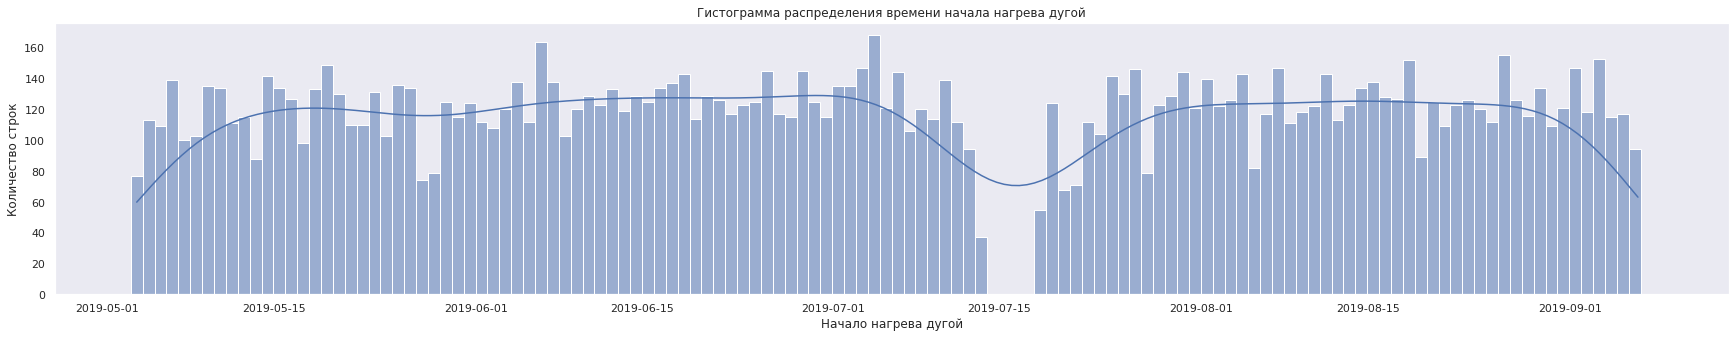

In [16]:
#строим гистограмму для признака 'Начало нагрева дугой' 
sns.set(rc={"figure.figsize": (30, 5)})
sns.set_style("dark")
ahs = sns.histplot(data=data_arc, x='Начало нагрева дугой', kde=True, discrete=True)
ahs.set_ylabel('Количество строк')
ahs.set_title('Гистограмма распределения времени начала нагрева дугой')


In [17]:
#смотрим, что за пропуск в седьмом месяце:
#возвращаем уникальные дни седьмого месяца, когда происходило начало нагрева дугой
data_arc['Начало нагрева дугой'].dt.day[data_arc['Начало нагрева дугой'].dt.month==7].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 18, 19, 20, 21,
       22, 23, 24, 25, 26, 27, 28, 29, 30, 31])

* Видим резкий спад 13 и 18 июля и отсутствие данных за 14-17 июля, возможно, это авария или сбой в сборе данных.

Text(0.5, 1.0, 'Гистограмма распределения времени конца нагрева дугой')

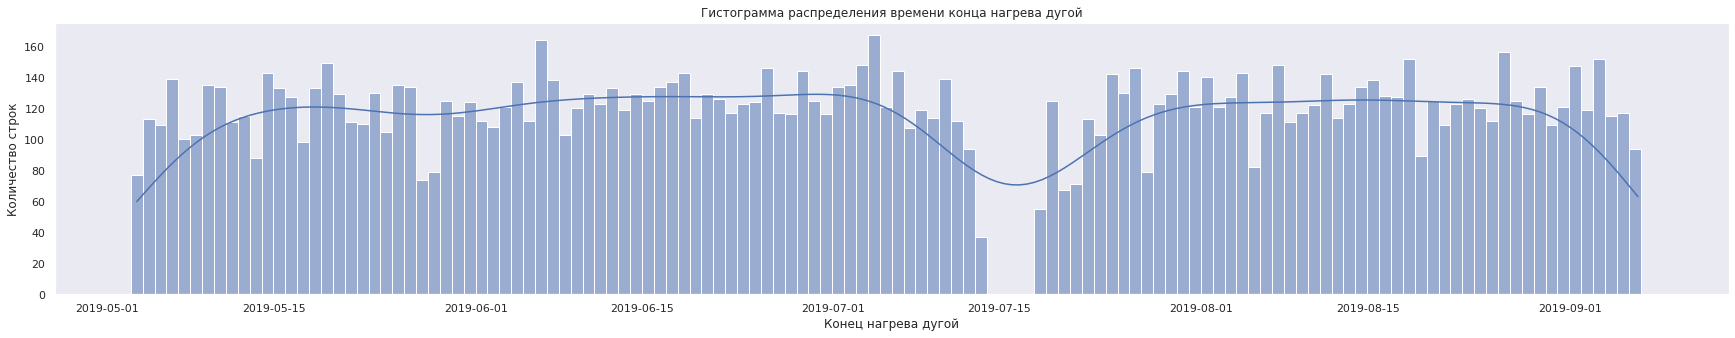

In [18]:
#строим гистограмму для признака 'Конец нагрева дугой' 
sns.set(rc={"figure.figsize": (30, 5)})
sns.set_style("dark")
ahf = sns.histplot(data=data_arc, x='Конец нагрева дугой', kde=True, discrete=True)
ahf.set_ylabel('Количество строк')
ahf.set_title('Гистограмма распределения времени конца нагрева дугой')

In [19]:
#смотрим, что за пропуск в седьмом месяце:
data_arc['Конец нагрева дугой'].dt.day[data_arc['Конец нагрева дугой'].dt.month==7].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 18, 19, 20, 21,
       22, 23, 24, 25, 26, 27, 28, 29, 30, 31])

* Пропуск точно такой же, как и в признаке 'Начало нагрева дугой'

Text(0.5, 0, 'Активная мощность')

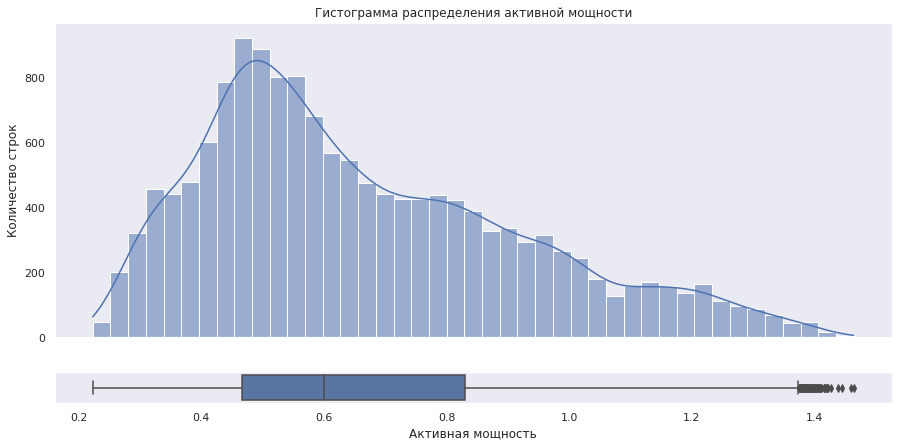

In [20]:
#строим гистограмму и боксплот для признака 'Активная мощность' 
_, [axs_hist, axs_box] = plt.subplots(2, 1, figsize=(15, 7),
                                      sharex=True,
                                      gridspec_kw=dict(height_ratios=[10,1]))

ap_hist = sns.histplot(data=data_arc, x='Активная мощность', kde=True, ax=axs_hist)
ap_hist.set_ylabel('Количество строк')
ap_hist.set_title('Гистограмма распределения активной мощности')

ap_box = sns.boxplot(data=data_arc, x='Активная мощность', ax=axs_box) 
ap_box.set_xlabel('Активная мощность')

Распределение активной мощности похоже на нормальное и Пуассона со смещением влево. 

Среднее — 0.66, медиана-0.6, стандартное отклонение — 0.26

In [21]:
#смотрим строки, в которой `Реактивная мощность` меньше нуля
data_arc[data_arc['Реактивная мощность'] <= 0]

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
9780,2116,2019-07-28 02:22:08,2019-07-28 02:23:57,0.705344,-715.479924


In [23]:
#поскольку отрицательной мощности не бывает в нашем случае, удалим её:
data_arc = data_arc.drop(data_arc[data_arc['Реактивная мощность'] <= 0].index).reset_index(drop=True)

Text(0.5, 0, 'Реактивная мощность')

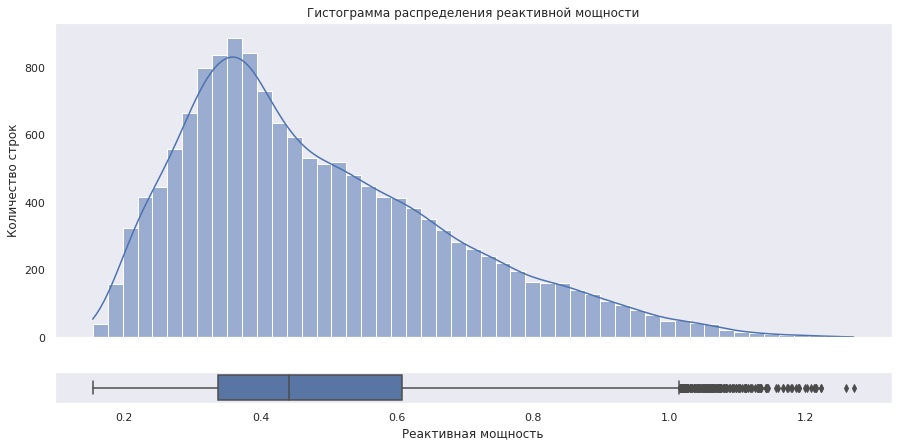

In [24]:
#строим гистограмму и боксплот для признака 'Реактивная мощность' 
_, [axs_hist, axs_box] = plt.subplots(2, 1, figsize=(15, 7),
                                      sharex=True,
                                      gridspec_kw=dict(height_ratios=[10,1]))

ap_hist = sns.histplot(data=data_arc, x='Реактивная мощность', kde=True, ax=axs_hist)
ap_hist.set_ylabel('Количество строк')
ap_hist.set_title('Гистограмма распределения реактивной мощности')

ap_box = sns.boxplot(data=data_arc, x='Реактивная мощность', ax=axs_box) 
ap_box.set_xlabel('Реактивная мощность')

In [25]:
print('std', data_arc['Реактивная мощность'].std().round(2))
print('mean', data_arc['Реактивная мощность'].mean().round(2))
print('median', data_arc['Реактивная мощность'].median().round(2))

std 0.2
mean 0.49
median 0.44


С учетом избавления от выброса распределение реактивной мощности также похоже на нормальное и Пуассона со смещением влево и хвостом справа. Среднее — 0.49, стандартное отклонение — 0.2, медиана — 0.44

## Данные о подаче сыпучих материалов / объём (data_bulk)

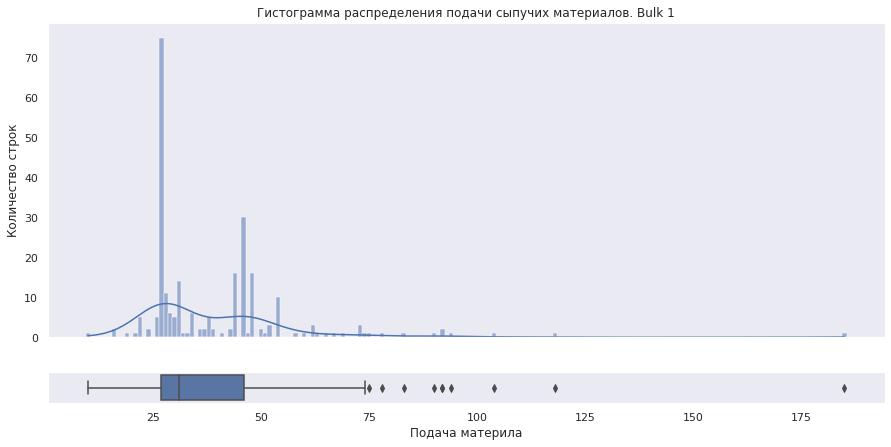

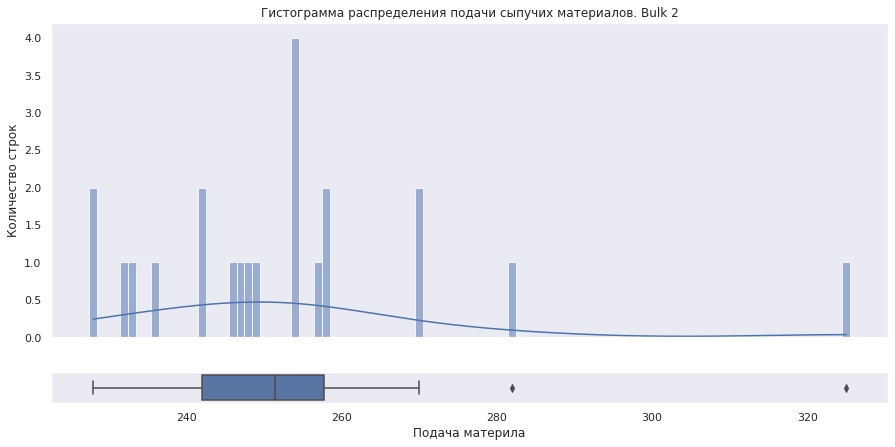

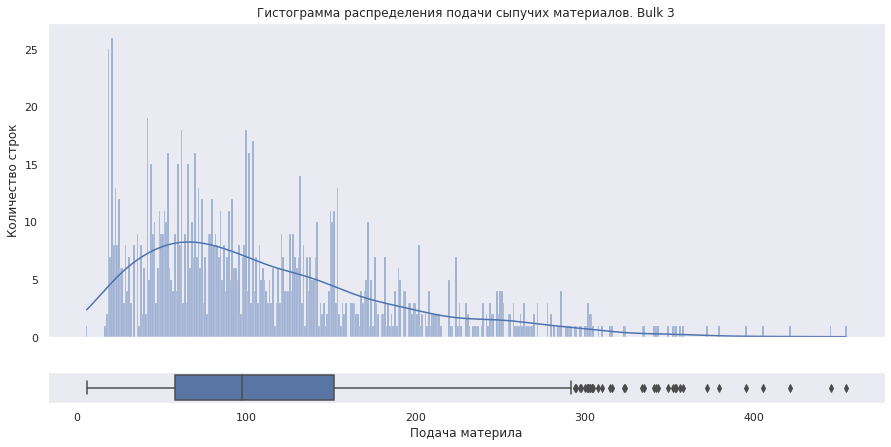

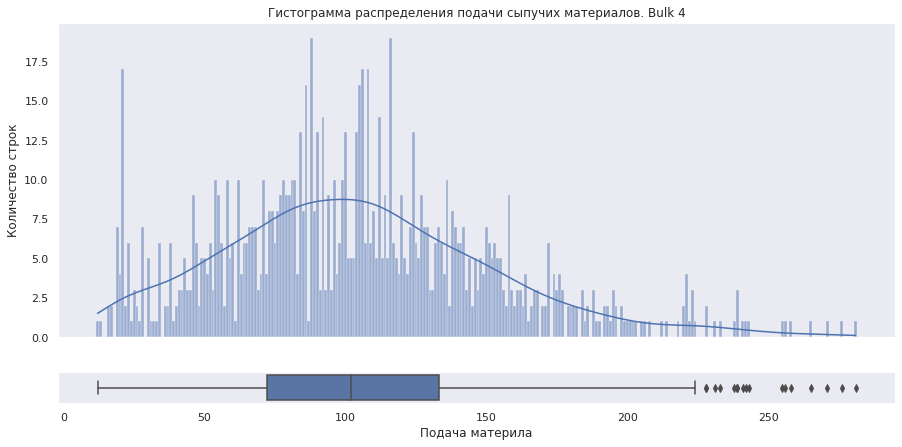

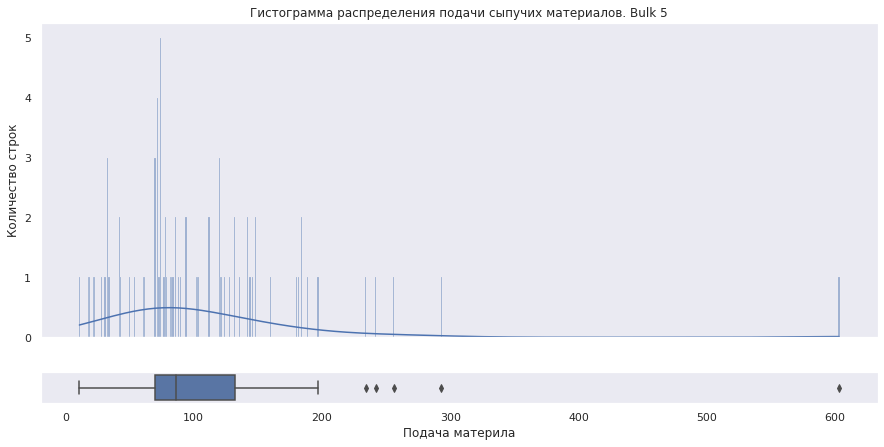

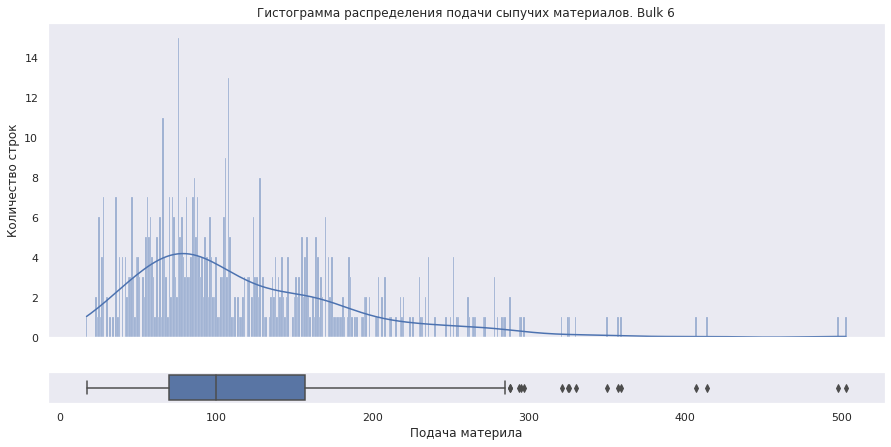

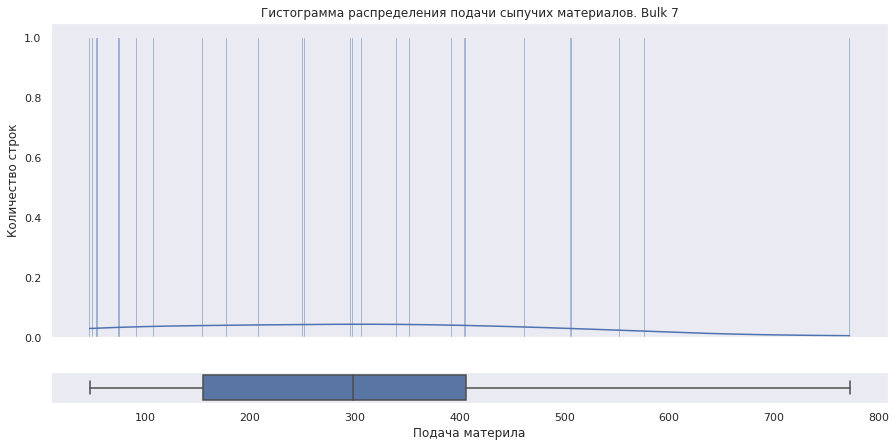

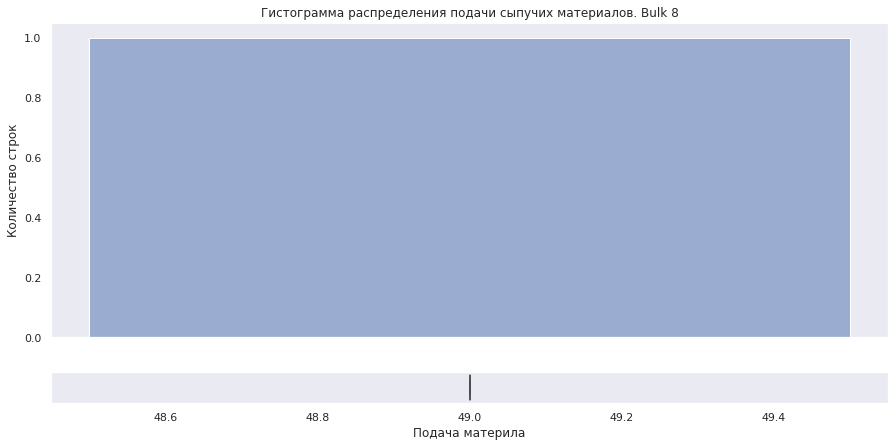

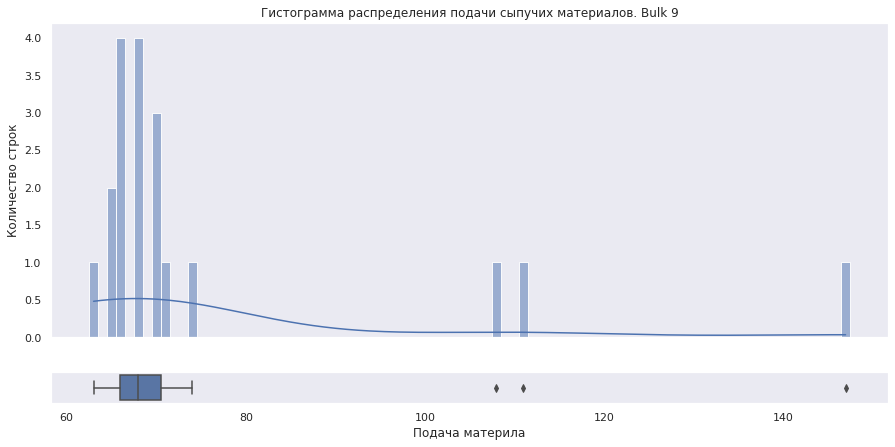

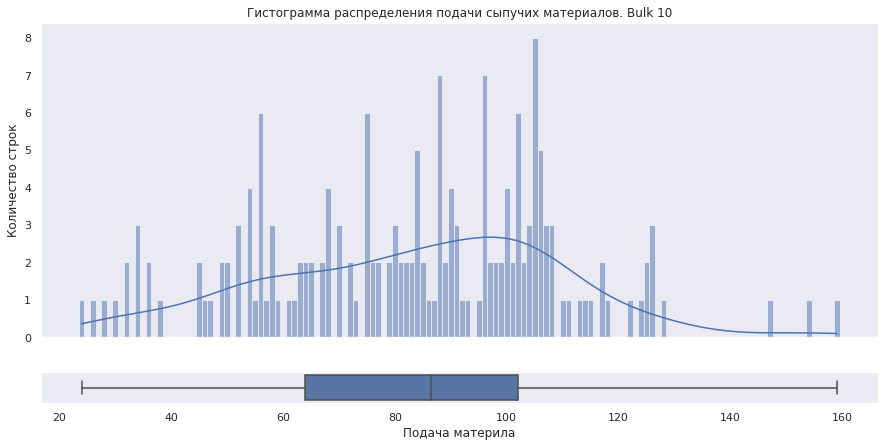

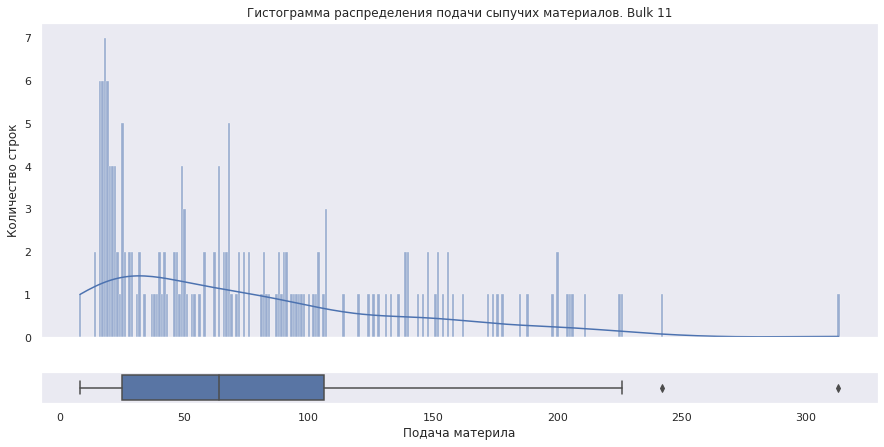

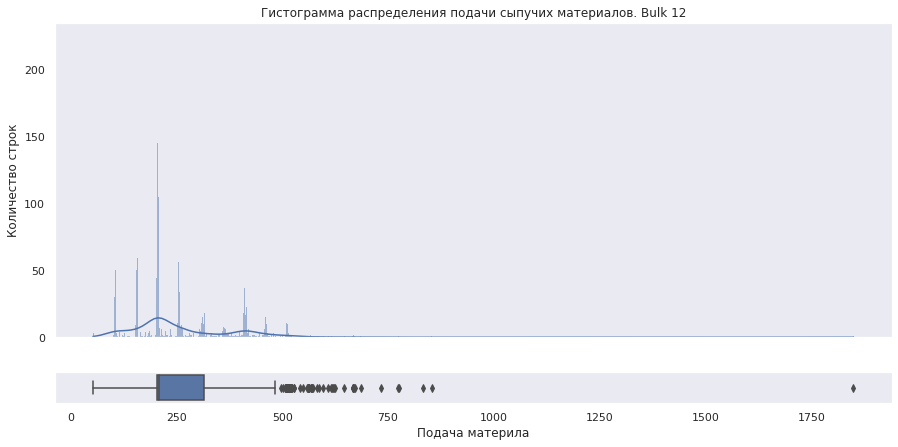

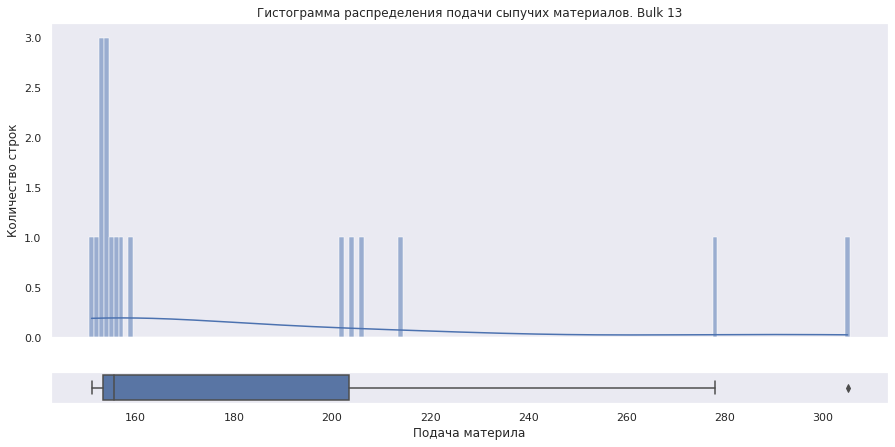

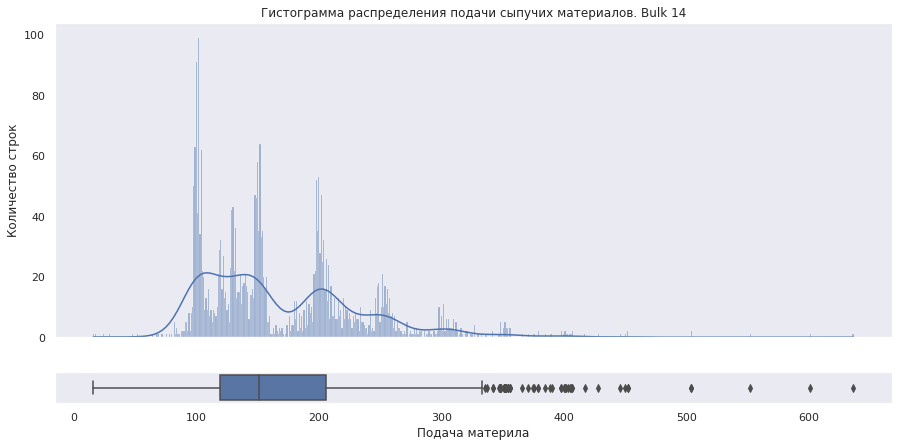

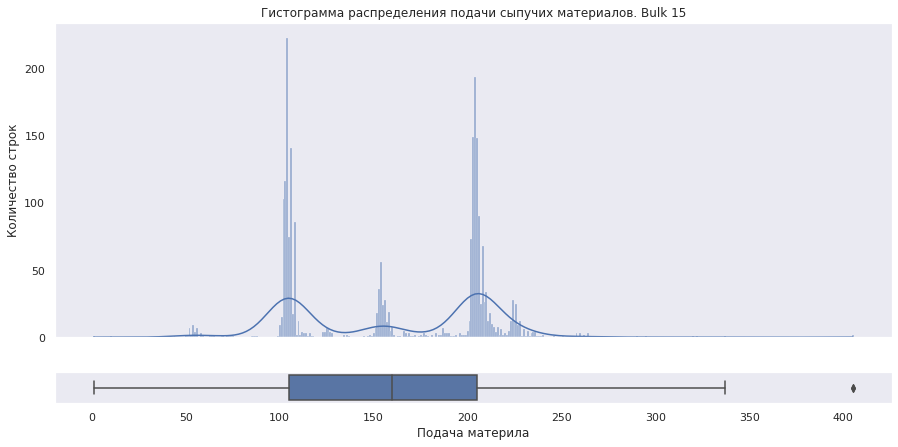

In [26]:
#строим гистограммы и боксплоты для каждого признака Bulk

bulks = data_bulk.columns.to_list()[1:]

for bulk in bulks:
    _, [axs_hist, axs_box] = plt.subplots(2, 1, figsize=(15, 7), 
                                          sharex=True,
                                          gridspec_kw=dict(height_ratios=[10,1]))
    
    bulk_hist = sns.histplot(data=data_bulk, x=bulk, kde=True, ax=axs_hist, discrete=True)
    bulk_hist.set_ylabel('Количество строк')
    bulk_hist.set_title('Гистограмма распределения подачи сыпучих материалов. ' + bulk)
    
    bulk_box = sns.boxplot(data=data_bulk, x=bulk, ax=axs_box)
    bulk_box.set_xlabel('Подача материла')

In [27]:
data_bulk.describe()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


По гистограммам видно, что сыпучие материалы добавляются в разных объемах, например, меньше всего в среднем добавляют `Bulk 1`, больше всего в среднем - `Bulk 7`. А чаще всего добавляют `Bulk 14`, и только 1 раз добавили `Bulk 8`. Почти на каждой гистограмме можно увидеть, что за 1 раз добавляется определенный объем легирующих добавок, так как столбцы гистограмм одинакового размера, особенно хорошо это заметно на `Bulk 10` и `Bulk 11`.

То есть разные сыпучие материалы (легирующие добавки) по-разному действуют на металл, а `Bulk 14` либо крайне редко использующаяся легирующая добавка, либо крайне дорогая, либо и то, и то.

## Данные о подаче сыпучих материалов / время (data_bulk_time)

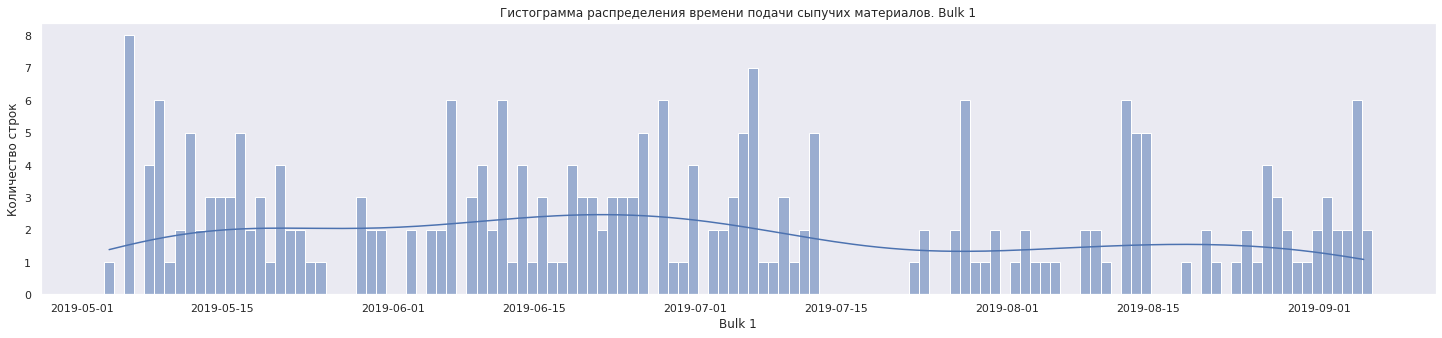

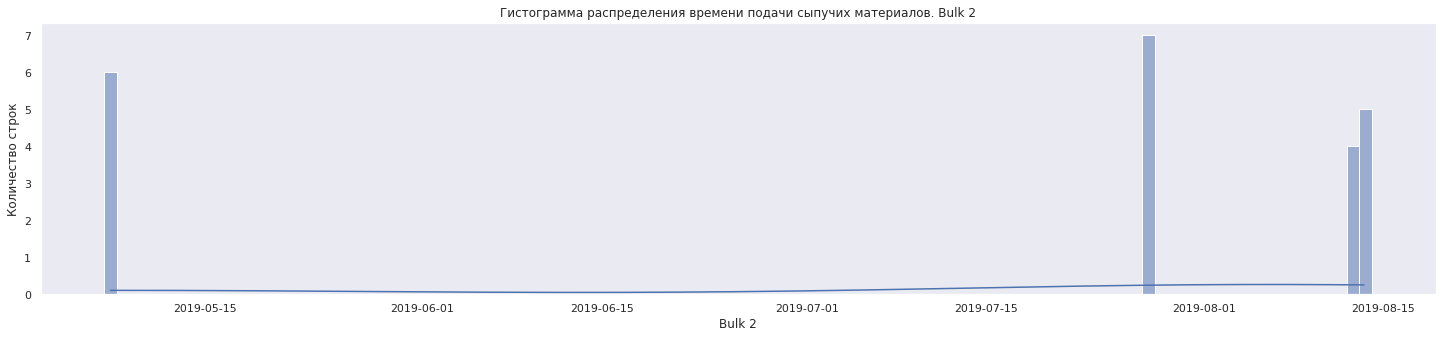

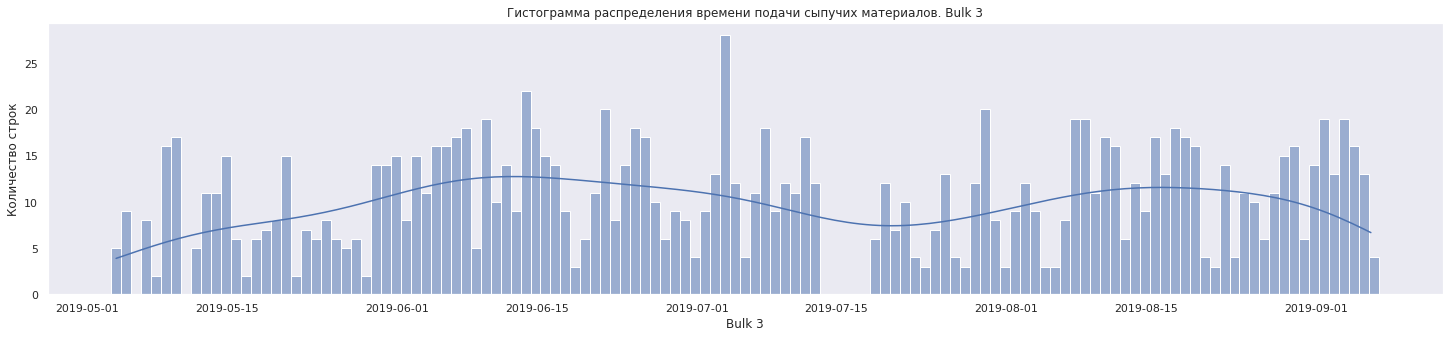

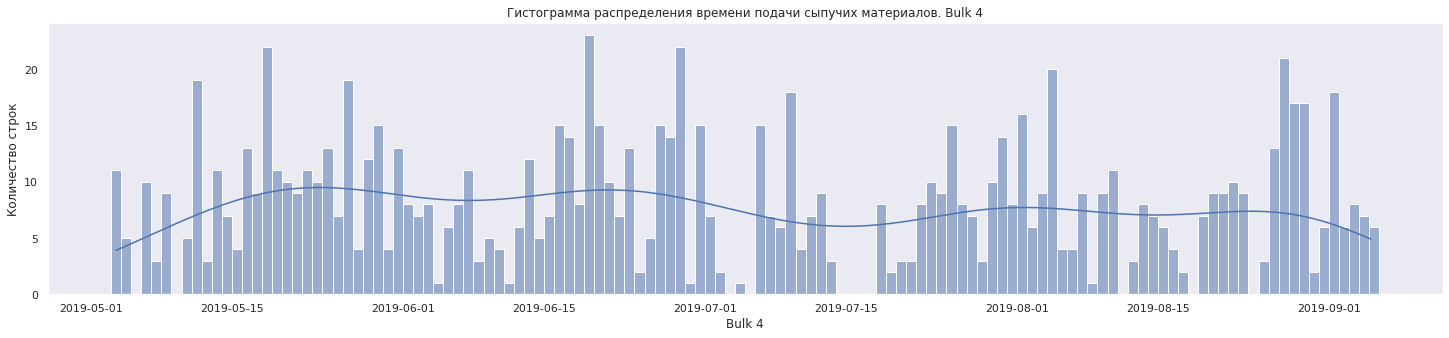

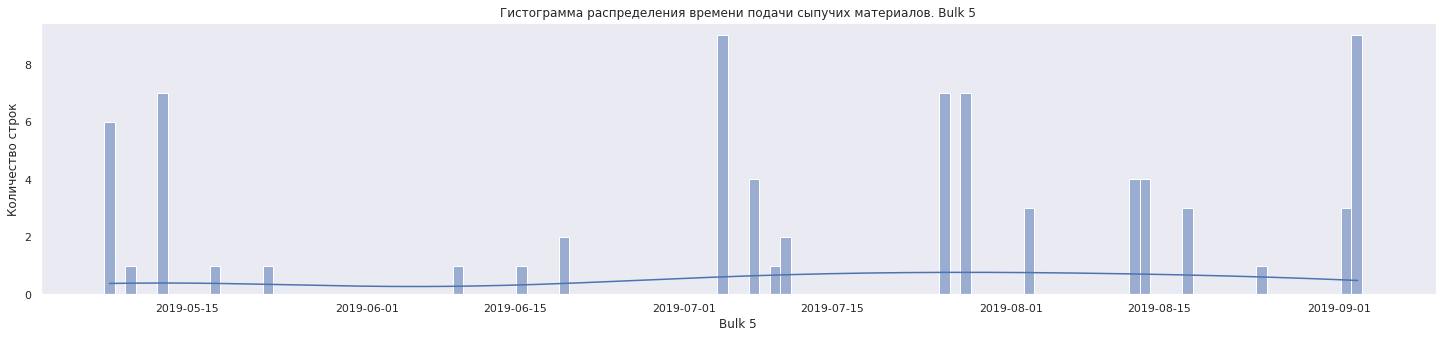

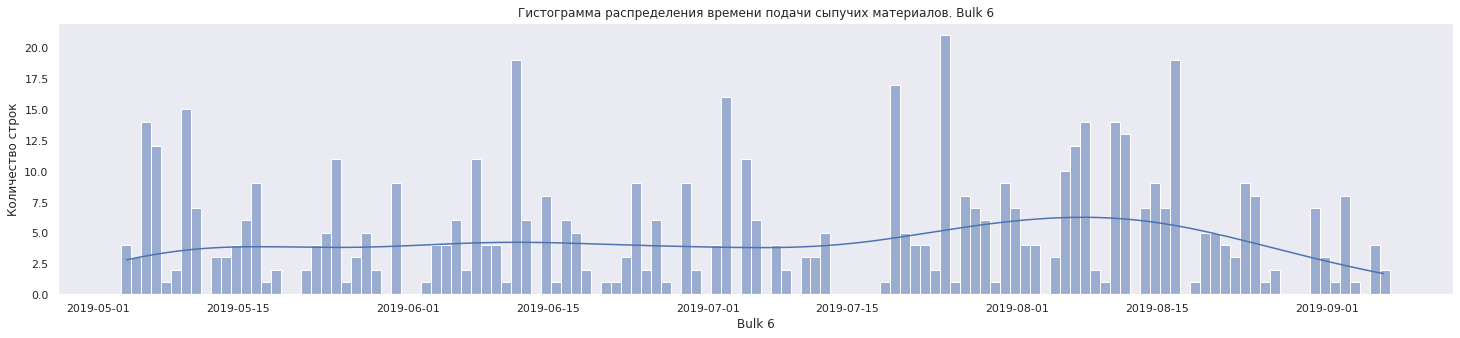

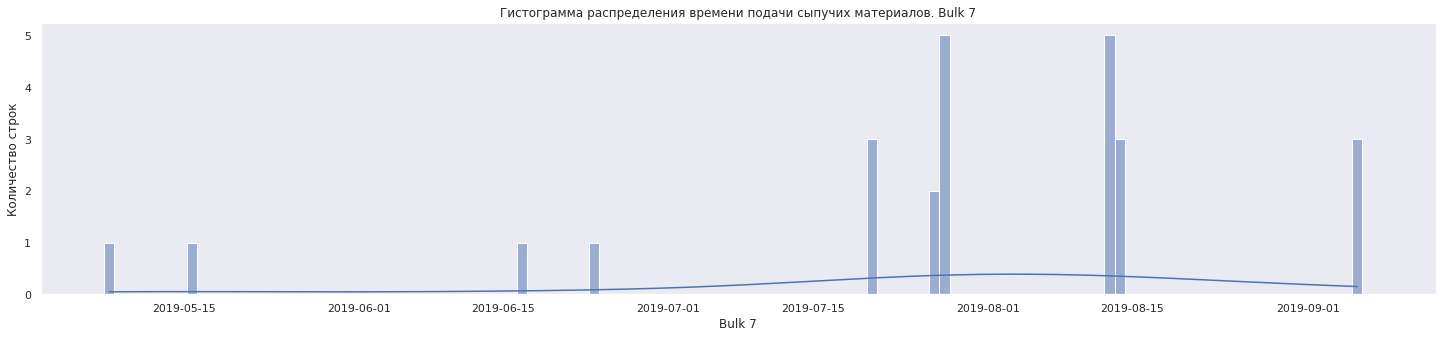

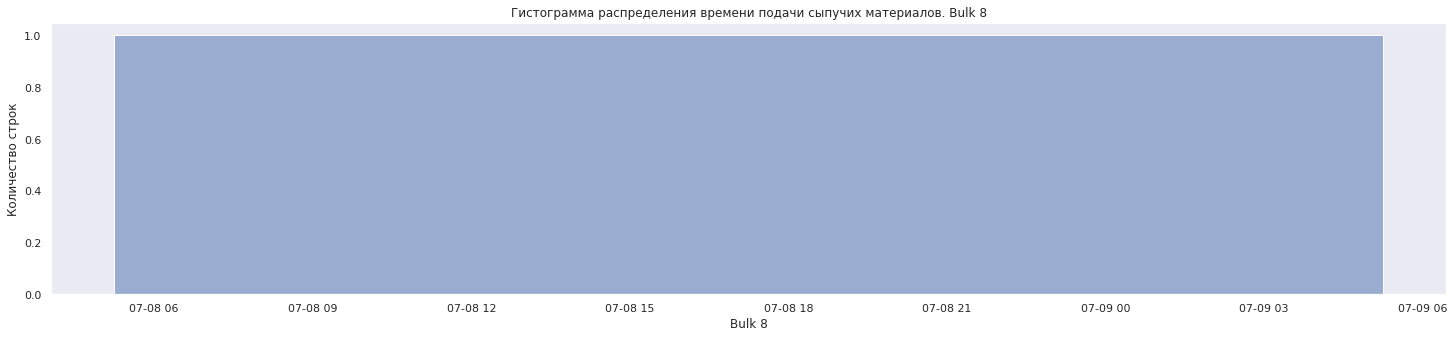

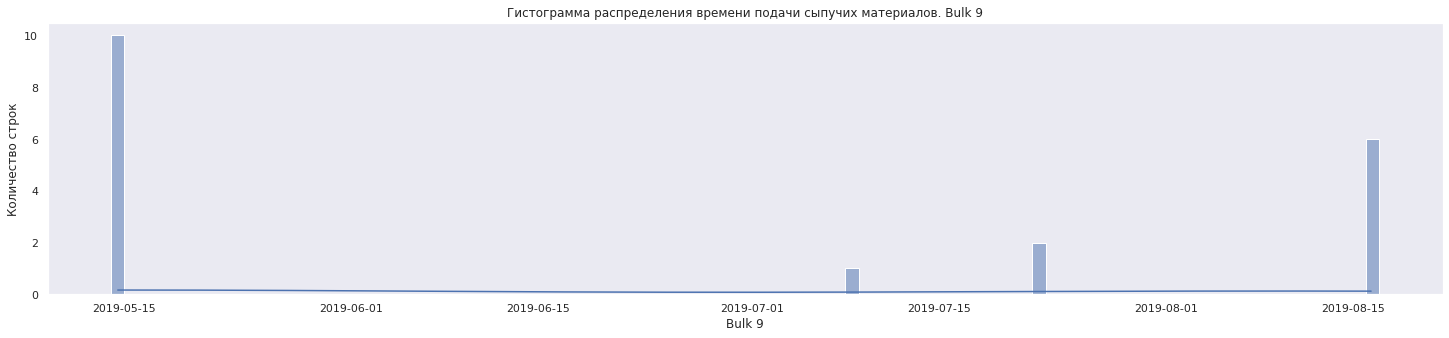

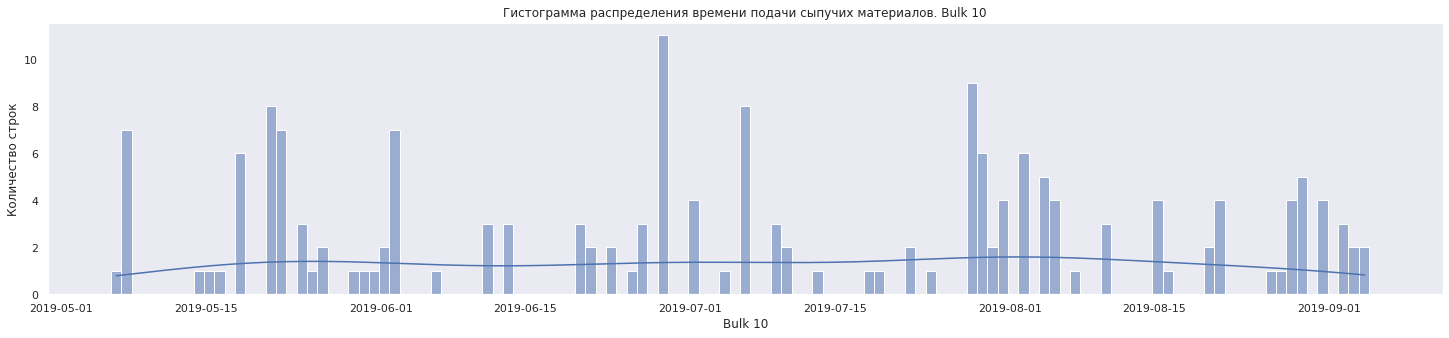

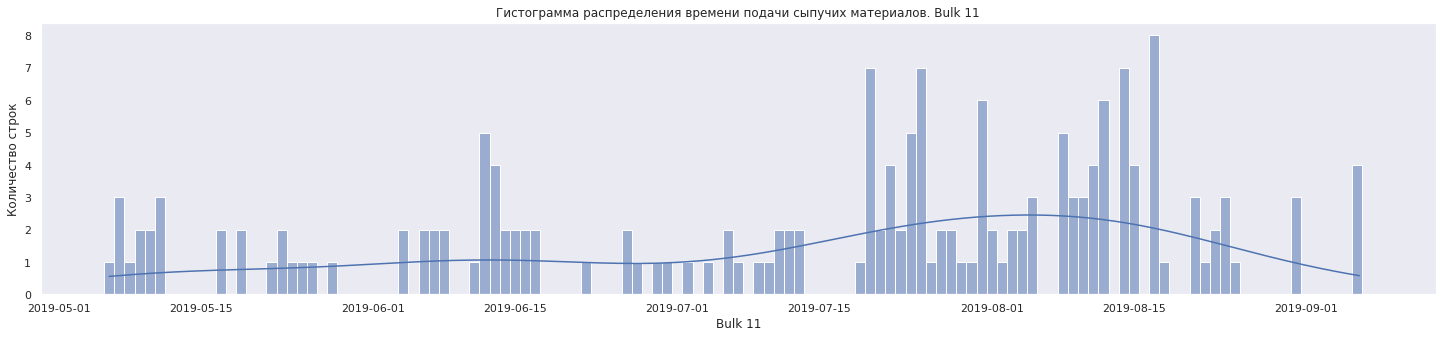

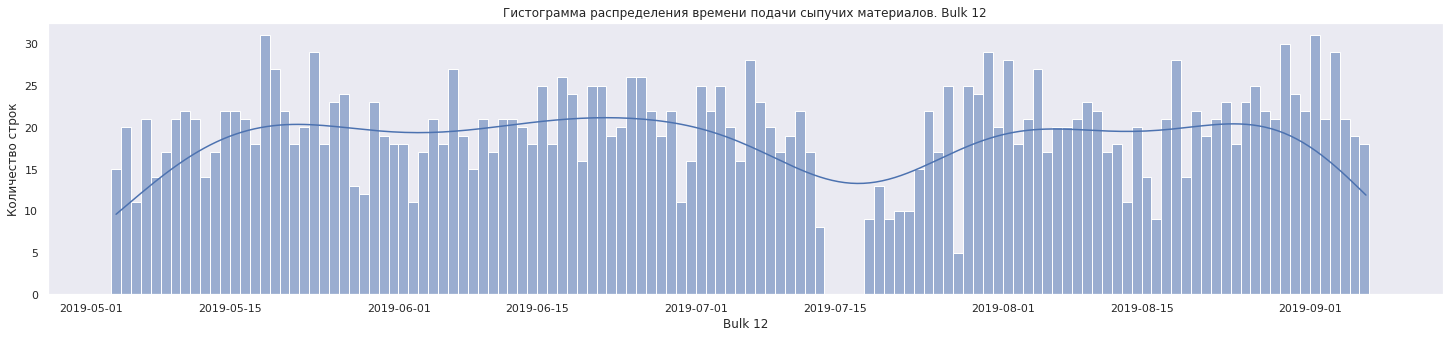

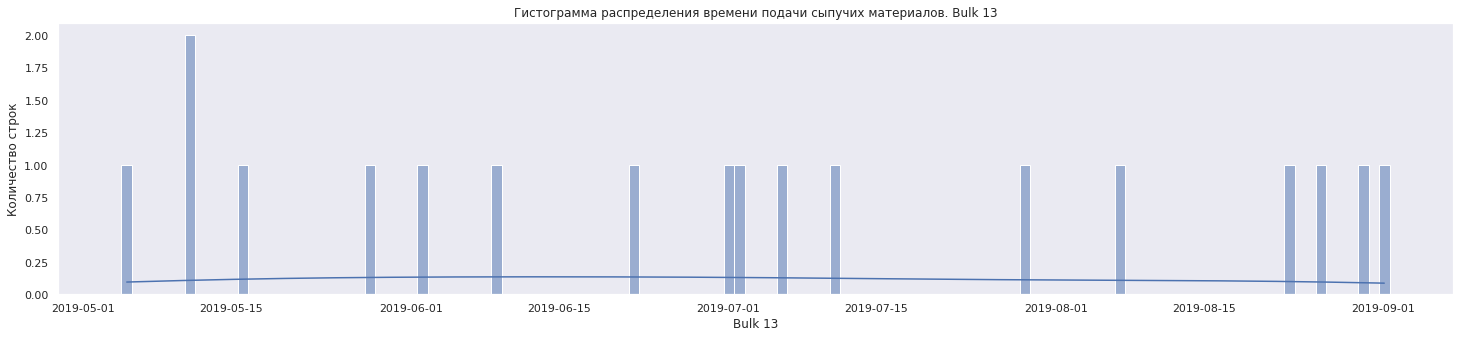

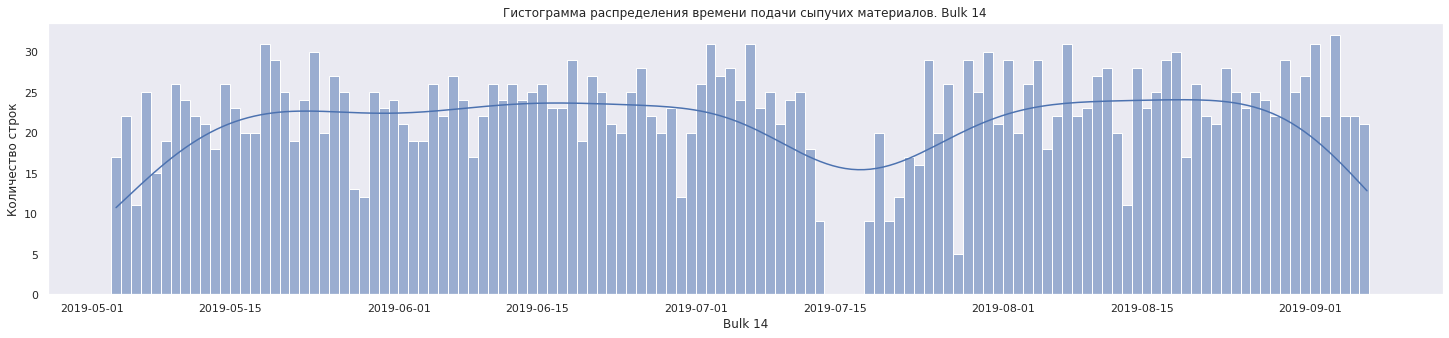

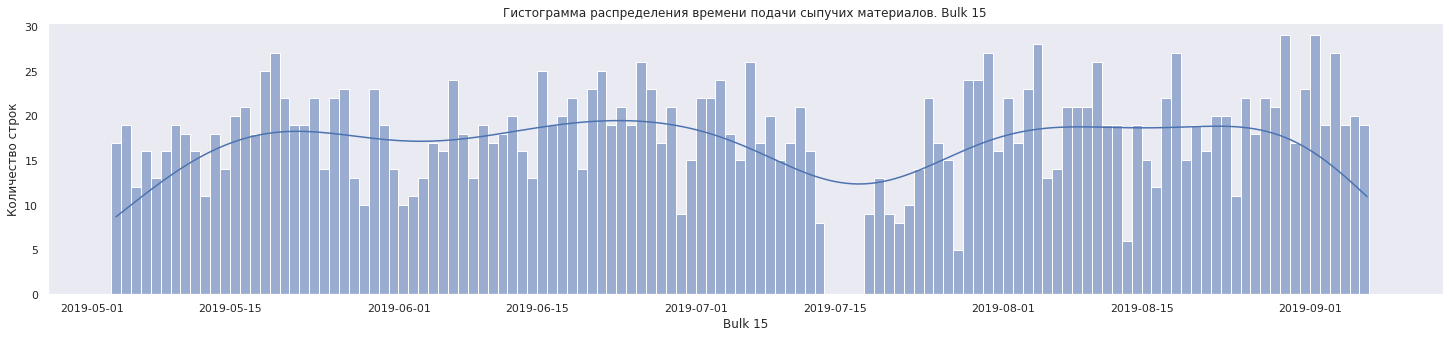

In [28]:
#названия признаков 'data_bulk_time' и 'data_bulk' одинаковые, поэтому использую bulks:
for bulk in bulks:
    sns.set(rc={"figure.figsize": (25, 5)})
    sns.set_style("dark")
    bulk_hist = sns.histplot(data=data_bulk_time, x=bulk, kde=True, discrete=True)
    bulk_hist.set_ylabel('Количество строк')
    bulk_hist.set_title('Гистограмма распределения времени подачи сыпучих материалов. ' + bulk)
    plt.show()

По гистограммам видно, что есть пропуск 14-17 июля, аналогичный пропуску в data_arc, что логично.

Нет закономерности, например, что в определнный день недели варим такой-то тип стали и добавляем такие-то добавки, то есть мы видим случайный выбор типа стали.

И в соответствие с датафреймом `data_bulk`, на гистограммах видно, что разные сыпучие легирующие добавки добавляют с разной частотой - чаще всего добавляют `Bulk 14`, `Bulk 12`и `Bulk 15`.

## Данные о продувке сплава газом (data_gas)

[Оглавление](#table)

Text(0.5, 0, 'Газ')

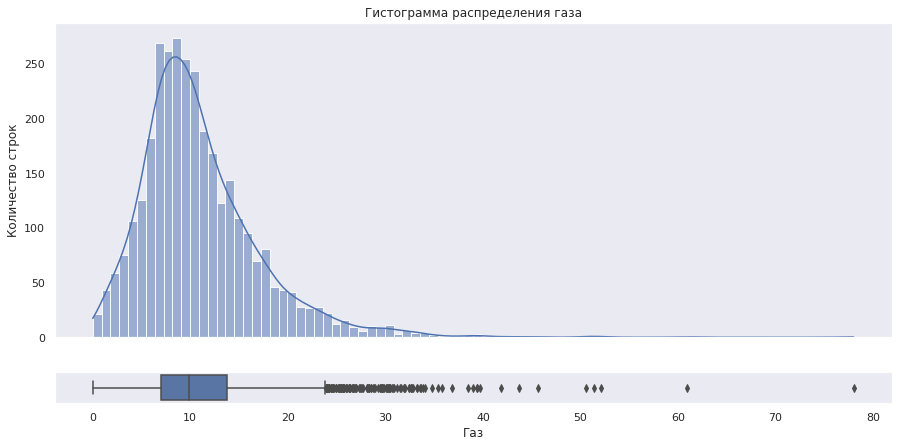

In [29]:
#строим гистограмму и боксплот для признака 'Газ 1' 
_, [axs_hist, axs_box] = plt.subplots(2, 1, figsize=(15, 7),
                                      sharex=True,
                                      gridspec_kw=dict(height_ratios=[10,1]))

gas_hist = sns.histplot(data=data_gas, x='Газ 1', kde=True, ax=axs_hist)
gas_hist.set_ylabel('Количество строк')
gas_hist.set_title('Гистограмма распределения газа')

gas_box = sns.boxplot(data=data_gas, x='Газ 1', ax=axs_box) 
gas_box.set_xlabel('Газ')

In [30]:
data_gas['Газ 1'].describe()

count    3239.000000
mean       11.002062
std         6.220327
min         0.008399
25%         7.043089
50%         9.836267
75%        13.769915
max        77.995040
Name: Газ 1, dtype: float64

Распределение газа также похоже на нормальное и Пуассона со смещением влево и хвостом справа. Среднее — 11, стандартное отклонение — 6.22, чаще всего продувают сплав 10 кубометрами газа

## Результаты измерения температуры (data_temp)

[Оглавление](#table)

Text(0.5, 1.0, 'Гистограмма распределения времени замера')

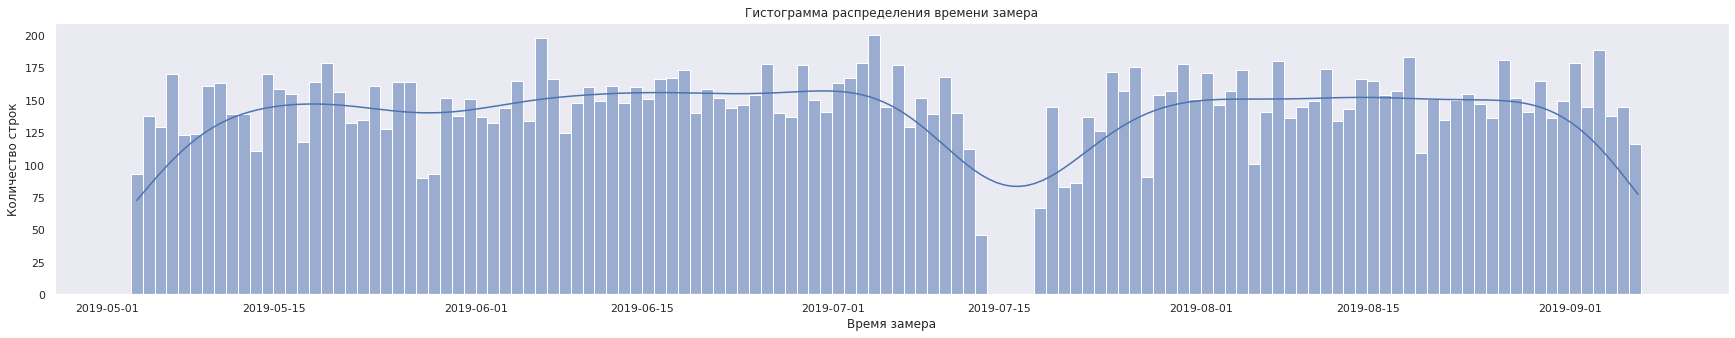

In [31]:
#строим гистограмму для признака 'Время замера' 
sns.set(rc={"figure.figsize": (30, 5)})
sns.set_style("dark")
ahf = sns.histplot(data=data_temp, x='Время замера', kde=True, discrete=True)
ahf.set_ylabel('Количество строк')
ahf.set_title('Гистограмма распределения времени замера')

Ожидаемо есть перерыв в работе 14-17 июля, как и в других гистограммах времени 

Text(0.5, 0, 'Температура')

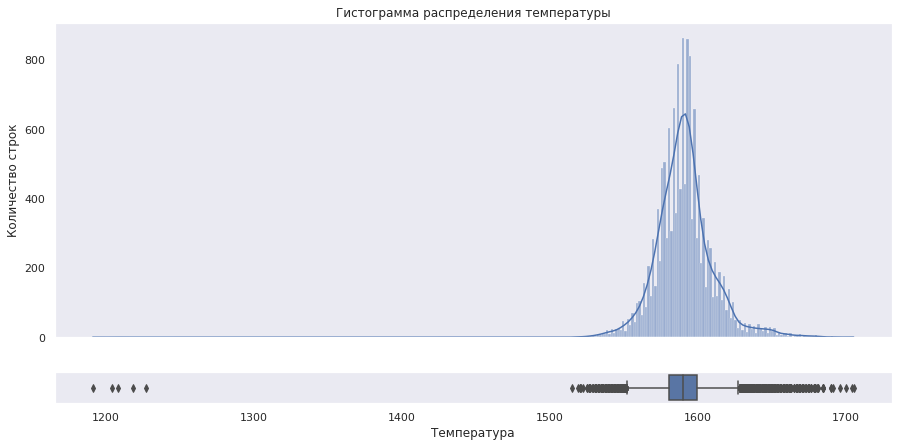

In [32]:
#строим гистограмму и боксплот для признака 'Температура' 
_, [axs_hist, axs_box] = plt.subplots(2, 1, figsize=(15, 7),
                                      sharex=True,
                                      gridspec_kw=dict(height_ratios=[10,1]))

temp_hist = sns.histplot(data=data_temp, x='Температура', kde=True, ax=axs_hist)
temp_hist.set_ylabel('Количество строк')
temp_hist.set_title('Гистограмма распределения температуры')

temp_box = sns.boxplot(data=data_temp, x='Температура', ax=axs_box) 
temp_box.set_xlabel('Температура')

Распределение похоже на нормальное. Есть выбросы - температура ниже 1500 градусов

Text(0.5, 0, 'Температура')

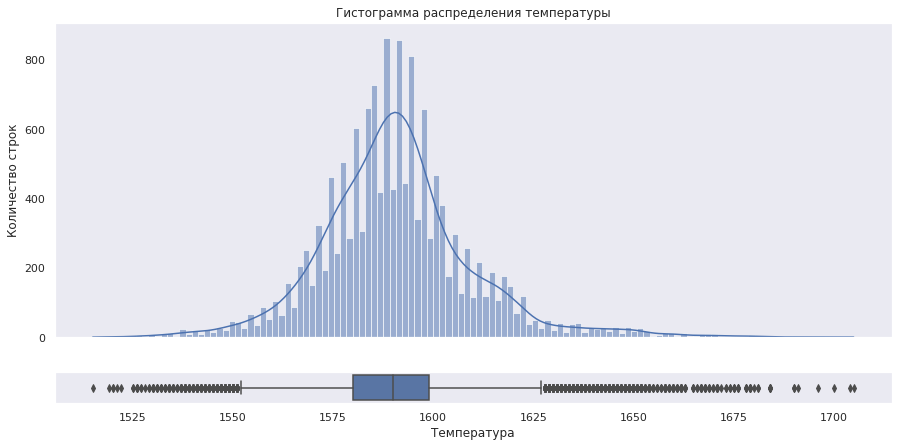

In [33]:
#строим гистограмму с температурой не ниже 1500
_, [axs_hist, axs_box] = plt.subplots(2, 1, figsize=(15, 7),
                                      sharex=True,
                                      gridspec_kw=dict(height_ratios=[10,1]))

temp_hist = sns.histplot(data=data_temp[data_temp['Температура']>=1500], x='Температура', kde=True, ax=axs_hist)
temp_hist.set_ylabel('Количество строк')
temp_hist.set_title('Гистограмма распределения температуры')

temp_box = sns.boxplot(data=data_temp[data_temp['Температура']>=1500], x='Температура', ax=axs_box) 
temp_box.set_xlabel('Температура')

In [34]:
data_temp[data_temp['Температура']>=1500].describe()

,key,Температура
count,14660.000000,14660.000000
mean,1325.369236,1590.852729
std,787.407873,19.143141
min,1.000000,1515.000000
25%,654.000000,1580.000000
50%,1314.000000,1590.000000
75%,1962.250000,1599.000000
max,3241.000000,1705.000000


Без выбросов среднее - 1591, отклонение - 19

## Данные о проволочных материалах / объем (data_wire)

[Оглавление](#table)

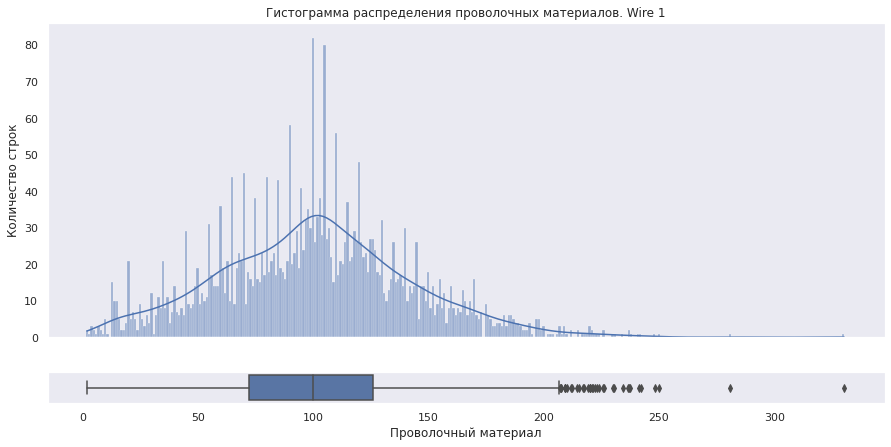

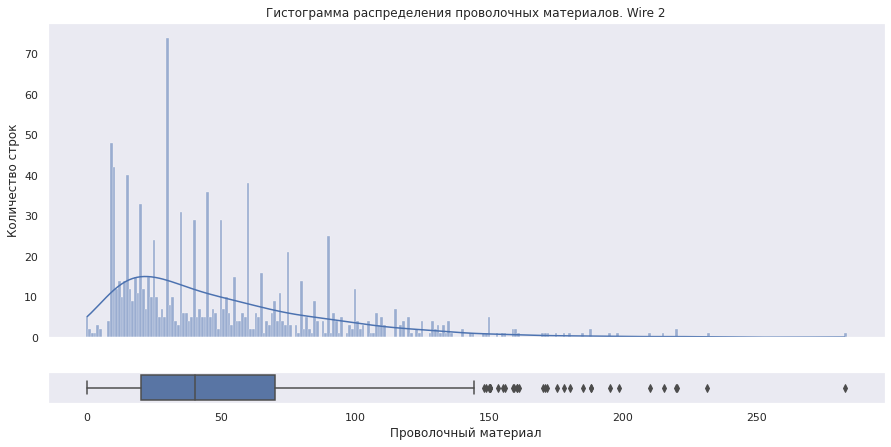

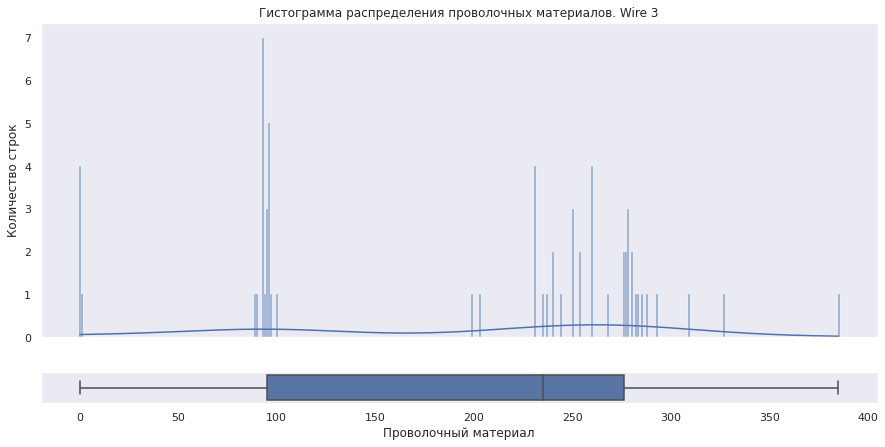

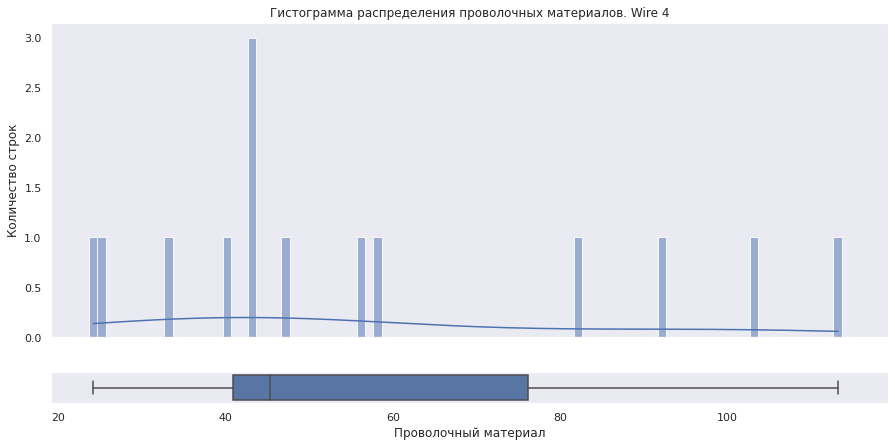

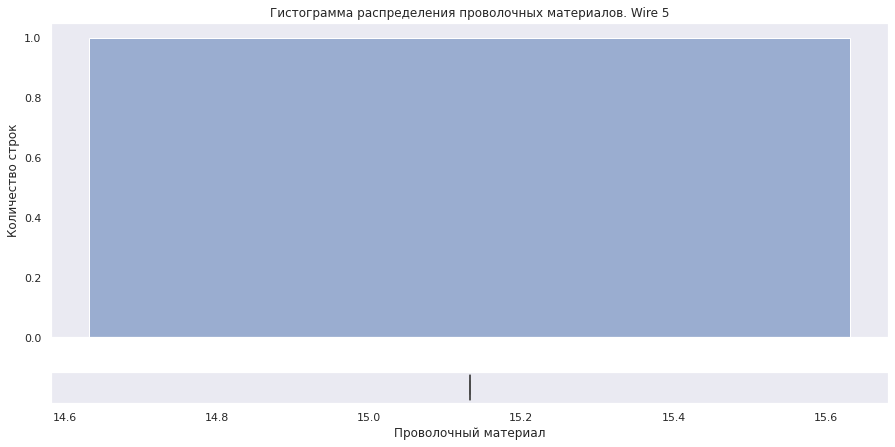

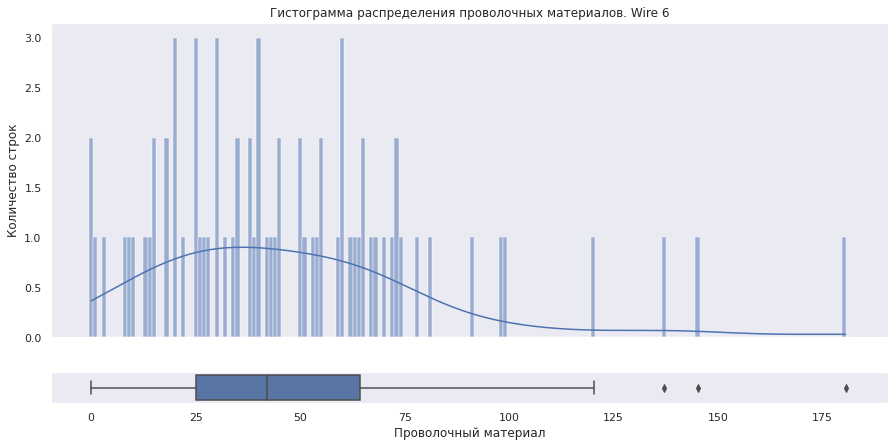

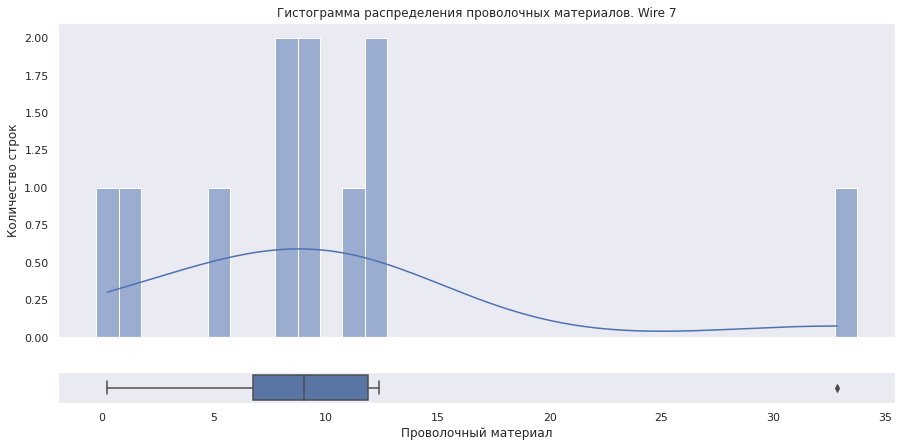

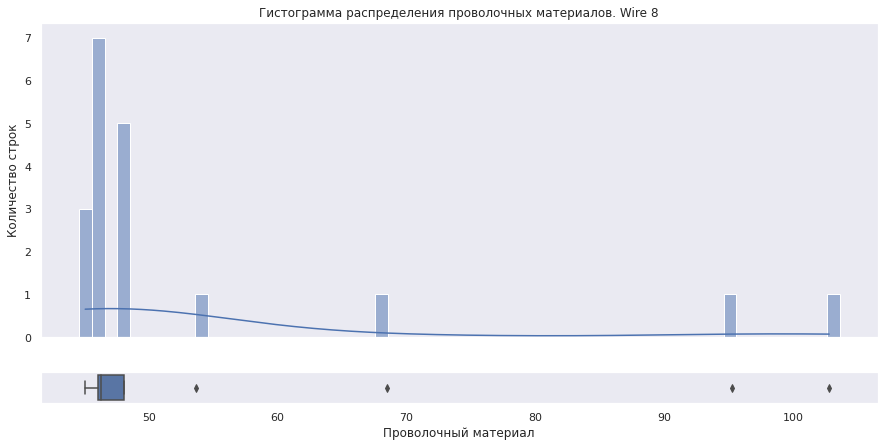

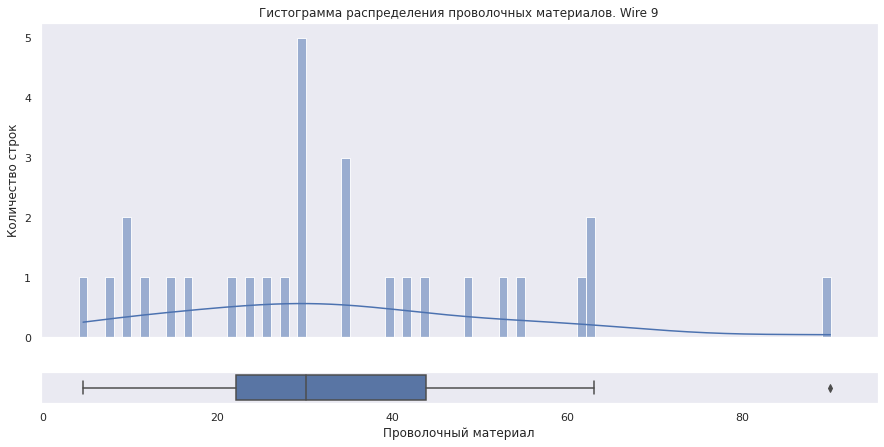

In [35]:
#строим гистограммы и боксплоты для признаков Wires

wires = data_wire.columns.to_list()[1:]

for wire in wires:
    _, [axs_hist, axs_box] = plt.subplots(2, 1, figsize=(15, 7),
                                      sharex=True,
                                      gridspec_kw=dict(height_ratios=[10,1]))

    wire_hist = sns.histplot(data=data_wire, x=wire, kde=True, discrete=True, ax=axs_hist)
    wire_hist.set_ylabel('Количество строк')
    wire_hist.set_title('Гистограмма распределения проволочных материалов. ' + wire)

    wire_box = sns.boxplot(data=data_wire, x=wire, ax=axs_box) 
    wire_box.set_xlabel('Проволочный материал')

Как и в случае с сыпучими материалами, видно, что разные виды проволоки добавляются в разных объемах, например, только 1 раз добавили `Wire 5`, меньше всего в среднем добавляют `Wire 7`, больше всего в среднем добавляют `Wire 3`.

На гистограммах `Wire 3`, `Wire 4`, `Wire 6`, `Wire 7`, `Wire 8`, `Wire 9` можно увидеть, что за 1 раз добавляется определенный объем проволоки.

Есть выбросы, но это можно списать на погрешности

## Данные о проволочных материалах / время (data_wire_time)

[Оглавление](#table)

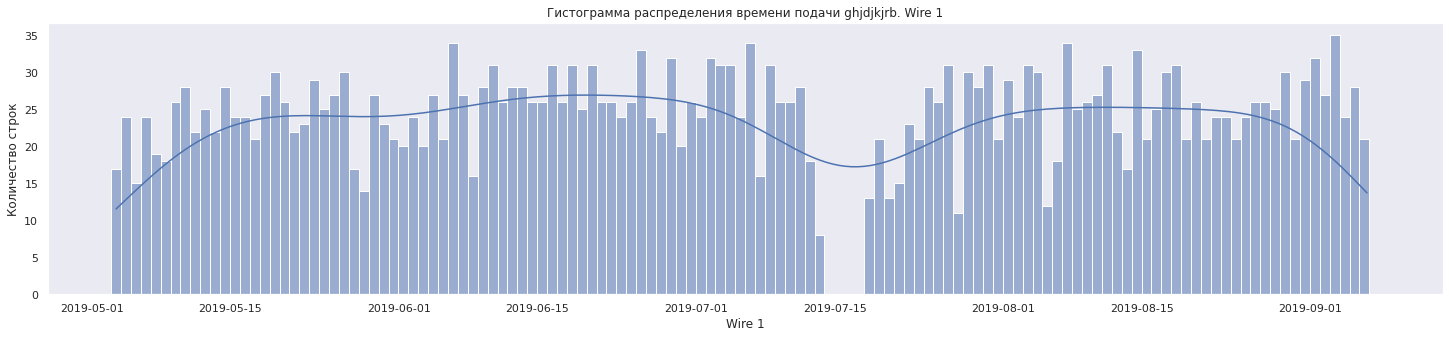

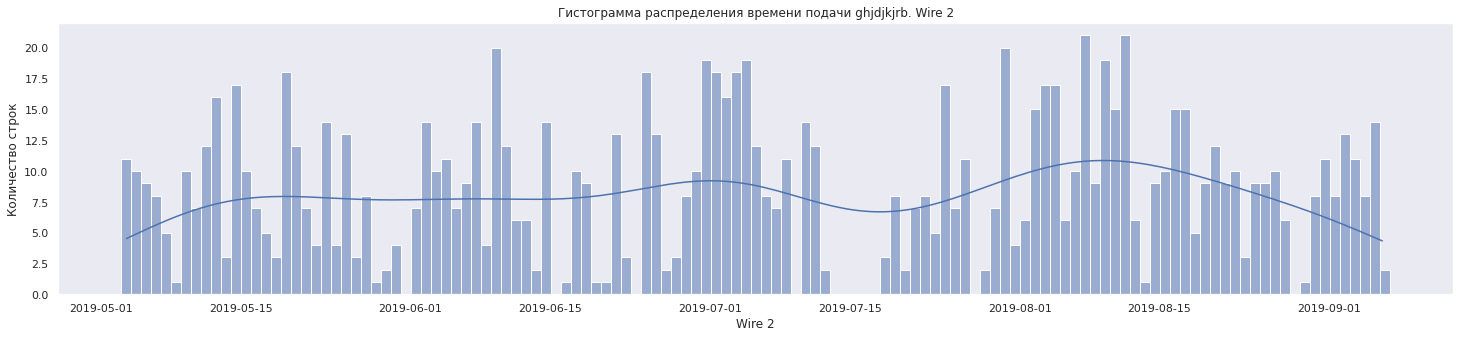

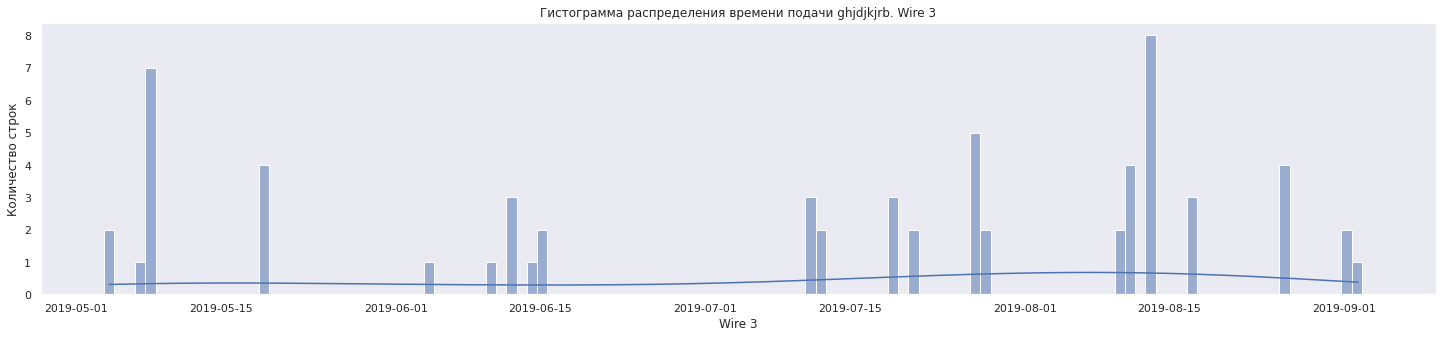

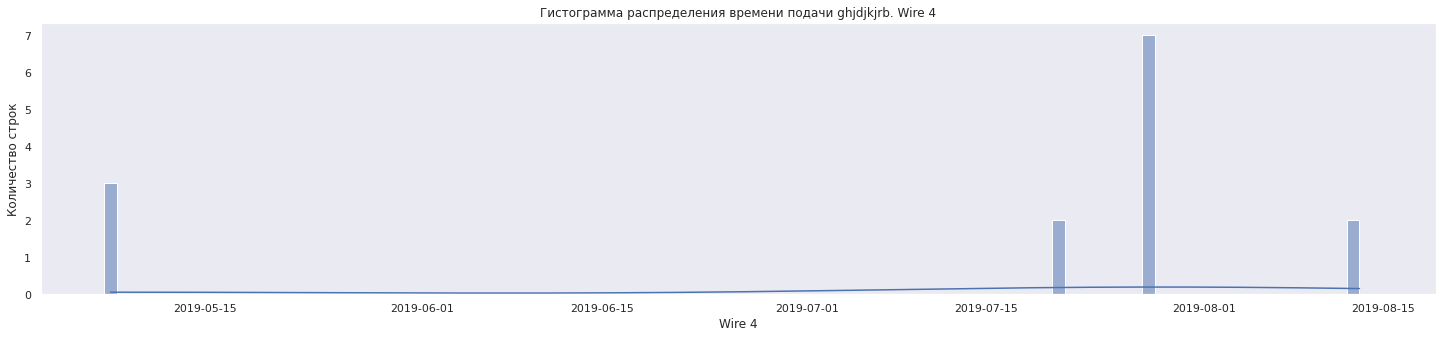

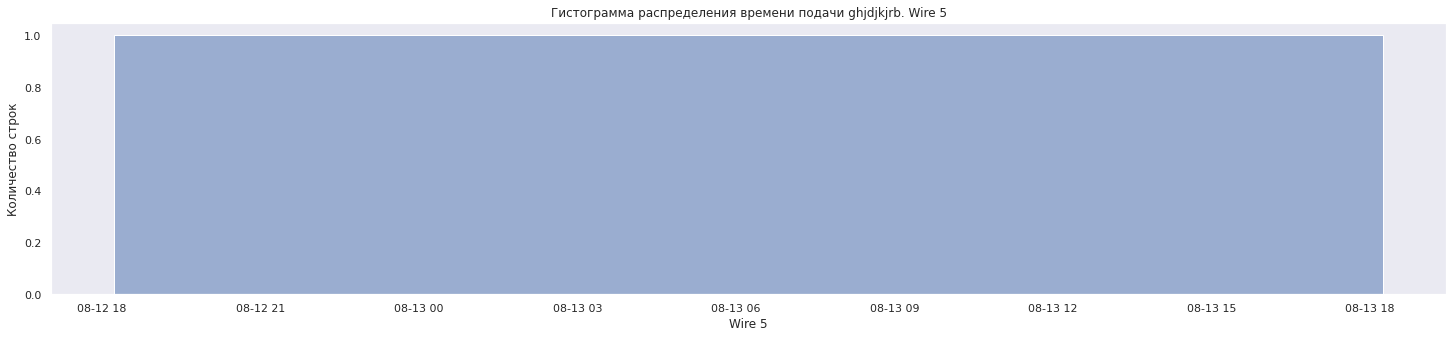

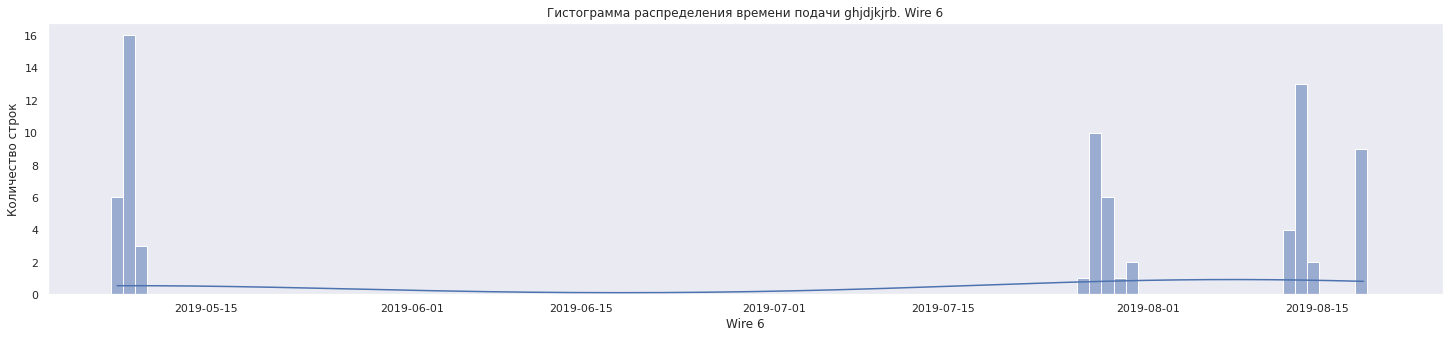

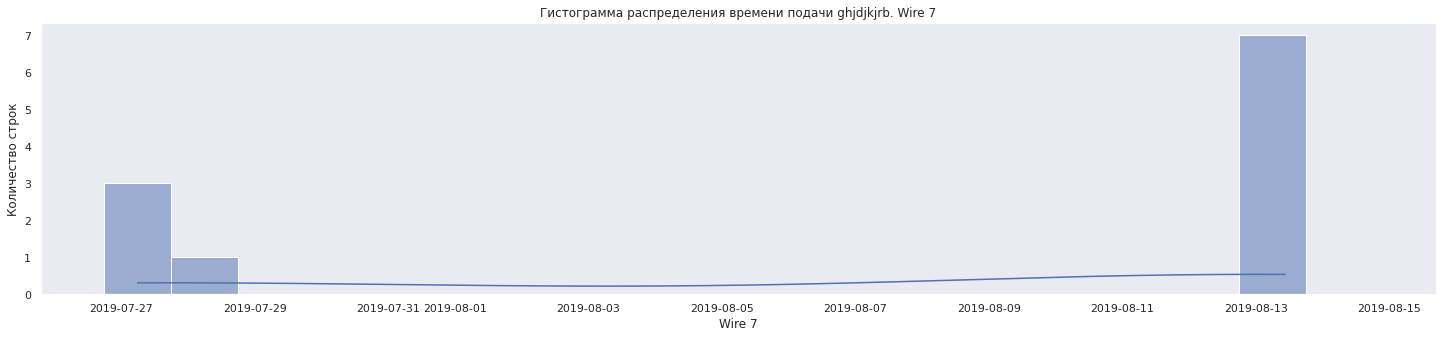

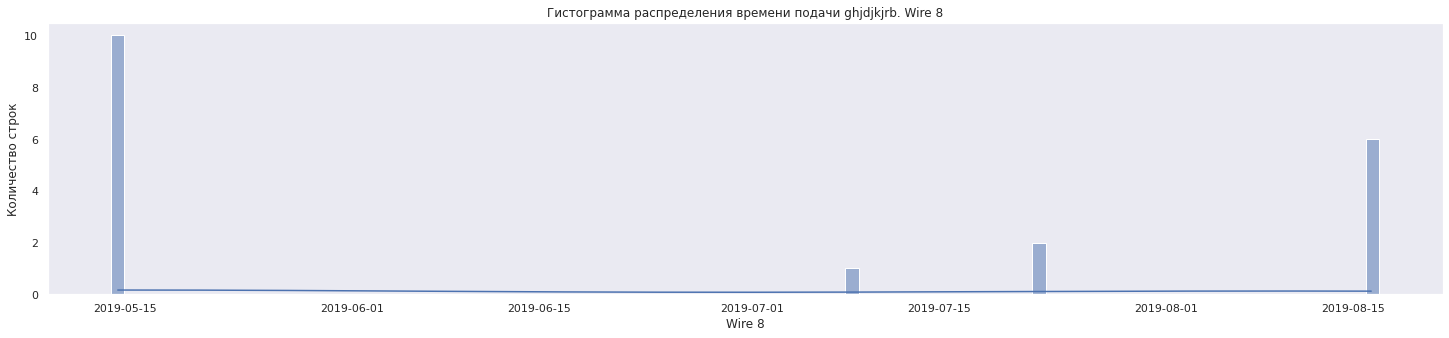

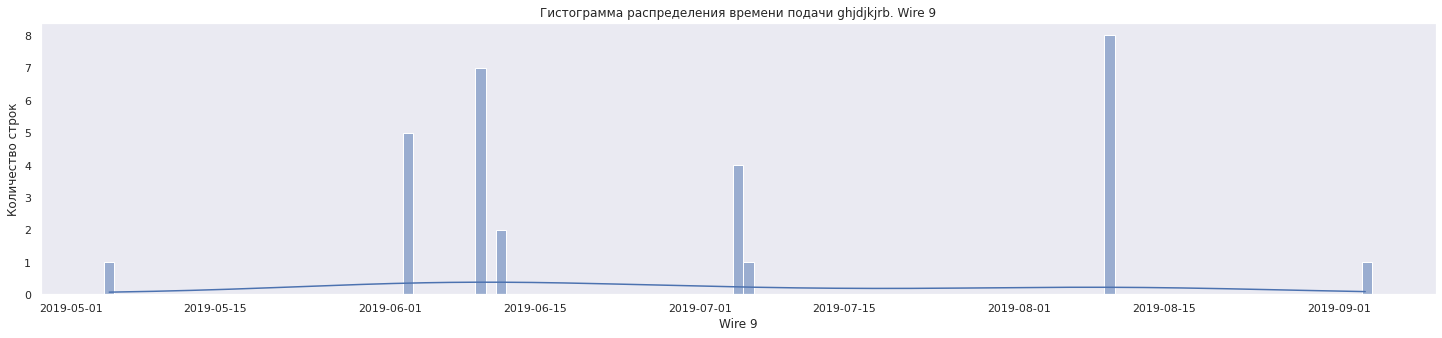

In [36]:
#строим гистограммы для признаков Wires
for wire in wires:
    sns.set(rc={"figure.figsize": (25, 5)})
    sns.set_style("dark")
    wire_hist = sns.histplot(data=data_wire_time, x=wire, kde=True, discrete=True)
    wire_hist.set_ylabel('Количество строк')
    wire_hist.set_title('Гистограмма распределения времени подачи ghjdjkjrb. ' + wire)
    plt.show()

По гистограммам видно, что есть пропуск 14-17 июля, аналогичный пропуску в data_arc, data_bulk_time, что логично.
В соответствие с датафреймом `data_wire`, на гистограммах видно, что разные проволоки добавляют с разной частотой.

## Выводы по п.3. EDA

1. В датафреймах data_bulk, data_bulk_time, data_wire, data_wire_time есть пропуски данных. Причина части пропусков известна от заказчика -  в определенных партиях не подавались легирующие добавки. 
2. В всех признаках времени нет данных на 14-17 июля
3. В части признаков есть выбросы - отрицательная реактивная мощность, низкая температура. 
4. Во всех таблицах количество значений `key` разное, это надо будет учесть при объединении.
5. Также по условию надо удалить все промежуточные температуры.

# Очистка данных. Заполнение данных

In [37]:
# добавим новый столбец с количеством итераций
data_temp['Количество итераций'] = data_temp['key'].map(data_temp['key'].value_counts())


In [38]:
data_temp.head()

,key,Время замера,Температура,Количество итераций
0,1,2019-05-03 11:02:04,1571.0,6
1,1,2019-05-03 11:07:18,1604.0,6
2,1,2019-05-03 11:11:34,1618.0,6
3,1,2019-05-03 11:18:04,1601.0,6
4,1,2019-05-03 11:25:59,1606.0,6


In [39]:
#удалим все промежуточные температуры из датафрейма data_temp

def temp_start_finish(data):
    data_temp_sorted = pd.DataFrame()
    for key in data['key'].unique():
        sorted = data[data['key']==key].sort_values(by='Время замера')
        data_temp_sorted = data_temp_sorted.append(sorted.head(1))
        data_temp_sorted = data_temp_sorted.append(sorted.tail(1))
    return data_temp_sorted

data_temp = temp_start_finish(data_temp)

data_temp

,key,Время замера,Температура,Количество итераций
0,1,2019-05-03 11:02:04,1571.0,6
5,1,2019-05-03 11:30:38,1613.0,6
6,2,2019-05-03 11:34:04,1581.0,5
10,2,2019-05-03 11:55:09,1602.0,5
11,3,2019-05-03 12:06:44,1596.0,6
...,...,...,...,...
18079,3239,2019-09-06 15:09:55,NaN,9
18080,3240,2019-09-06 15:25:21,1617.0,6
18085,3240,2019-09-06 16:35:26,NaN,6
18086,3241,2019-09-06 16:48:55,1586.0,6


In [40]:
#удалим все строки с партиями, где нет данных по финишной температуре
key_NaN = data_temp[data_temp['Температура'].isna()]['key'].unique()
data_temp = data_temp[~data_temp['key'].isin(key_NaN)]
data_temp

,key,Время замера,Температура,Количество итераций
0,1,2019-05-03 11:02:04,1571.0,6
5,1,2019-05-03 11:30:38,1613.0,6
6,2,2019-05-03 11:34:04,1581.0,5
10,2,2019-05-03 11:55:09,1602.0,5
11,3,2019-05-03 12:06:44,1596.0,6
...,...,...,...,...
13914,2497,2019-08-10 12:53:28,1589.0,4
13915,2498,2019-08-10 12:58:11,1591.0,6
13920,2498,2019-08-10 13:23:31,1594.0,6
13921,2499,2019-08-10 13:33:21,1569.0,5


In [41]:
#удалим все строки с партиями, где температура <= 1500
key_1500 = data_temp[data_temp['Температура'] <= 1500]['key'].unique()
data_temp = data_temp[~data_temp['key'].isin(key_1500)]
data_temp = data_temp.reset_index(drop=True)
data_temp

,key,Время замера,Температура,Количество итераций
0,1,2019-05-03 11:02:04,1571.0,6
1,1,2019-05-03 11:30:38,1613.0,6
2,2,2019-05-03 11:34:04,1581.0,5
3,2,2019-05-03 11:55:09,1602.0,5
4,3,2019-05-03 12:06:44,1596.0,6
...,...,...,...,...
4941,2497,2019-08-10 12:53:28,1589.0,4
4942,2498,2019-08-10 12:58:11,1591.0,6
4943,2498,2019-08-10 13:23:31,1594.0,6
4944,2499,2019-08-10 13:33:21,1569.0,5


In [42]:
#заполним нулями пропуски в data_bulk и data_wire
data_bulk.fillna(0, inplace=True)
data_wire.fillna(0, inplace=True)

## Вывод по п.4. Очистка данных. Заполнение данных:

- удалили ранее отрицательную мощность, также удалили промежуточные температуры и температуру ниже 1500. Датафрейм `data_temp` сократился с 18092 до 4946 строк, то есть при разбиении таблицы на стартовую и финальную температуры одной партии должно получиться 2473 строки. 
- пропуски в data_bulk и data_wire заполнили нулями (в data_bulk_time и data_wire_time заменять не стали, так как эти датафреймы не понадобятся - нужные данные по времени есть в data_arc)

# Построение единой таблицы

In [43]:
#вычисляем время между первым и последним замером температуры
#стартовая и финальная температуры - в отдельные столбцы-признаки

def delta_temp(data):
    list = []
    
    for key in data['key'].unique():
        tmp = data[data['key']==key].reset_index(drop=True)
        start = tmp.loc[0,'Температура']
        finish = tmp.loc[1,'Температура']
        delta = (tmp.loc[1,'Время замера'] - tmp.loc[0,'Время замера']).seconds
        iterations = tmp.loc[0, 'Количество итераций']
        
        list.append([key, start, finish, delta, iterations])
    
    return pd.DataFrame(list,
                        columns=['key',
                                 'Температура в начале',
                                 'Температура в конце. Целевой признак',
                                 'Время между замерами в сек', 
                                 'Количество итераций'])

data_temp = delta_temp(data_temp)
data_temp

,key,Температура в начале,Температура в конце. Целевой признак,Время между замерами в сек,Количество итераций
0,1,1571.0,1613.0,1714,6
1,2,1581.0,1602.0,1265,5
2,3,1596.0,1599.0,1753,6
3,4,1601.0,1625.0,1220,5
4,5,1576.0,1602.0,1536,5
...,...,...,...,...,...
2468,2495,1570.0,1591.0,1380,5
2469,2496,1554.0,1591.0,1705,7
2470,2497,1571.0,1589.0,962,4
2471,2498,1591.0,1594.0,1520,6


In [44]:
#вычисляем время нагрева электродами по всем промежуткам для data_arc

data_arc['Время нагрева в сек'] = (data_arc['Конец нагрева дугой'] - 
                                   data_arc['Начало нагрева дугой']).dt.seconds
data_arc

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,Время нагрева в сек
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253,228
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438,185
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460,172
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979,365
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691,148
...,...,...,...,...,...,...
14870,3241,2019-09-06 16:49:05,2019-09-06 16:51:42,0.439735,0.299579,157
14871,3241,2019-09-06 16:55:11,2019-09-06 16:58:11,0.646498,0.458240,180
14872,3241,2019-09-06 17:06:48,2019-09-06 17:09:52,1.039726,0.769302,184
14873,3241,2019-09-06 17:21:58,2019-09-06 17:22:55,0.530267,0.361543,57


**Полная мощность**

Вычислим значение полной мощности S:  
Соотношение полной мощности с активной и реактивной мощностями выражается в следующем виде:  
$$ S=\sqrt{P^2 + Q^2} $$  
, где P — активная мощность, Q — реактивная мощность 


[wiki](https://ru.wikipedia.org/wiki/%D0%AD%D0%BB%D0%B5%D0%BA%D1%82%D1%80%D0%B8%D1%87%D0%B5%D1%81%D0%BA%D0%B0%D1%8F_%D0%BC%D0%BE%D1%89%D0%BD%D0%BE%D1%81%D1%82%D1%8C)


**Работа (новый признак)**
* `Работа`= `Полная мощность` * `Время нагрева в сек`

In [45]:
#вычисляем `Работу` для data_arc
data_arc['Полная мощность'] = (data_arc['Активная мощность']**2 + data_arc['Реактивная мощность']**2)**0.5
data_arc['Работа'] = data_arc['Время нагрева в сек'] * data_arc['Полная мощность']
data_arc

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,Время нагрева в сек,Полная мощность,Работа
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253,228,0.371123,84.616003
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438,185,0.902319,166.928978
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460,172,0.722536,124.276277
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979,365,0.642824,234.630603
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691,148,1.079934,159.830252
...,...,...,...,...,...,...,...,...
14870,3241,2019-09-06 16:49:05,2019-09-06 16:51:42,0.439735,0.299579,157,0.532085,83.537345
14871,3241,2019-09-06 16:55:11,2019-09-06 16:58:11,0.646498,0.458240,180,0.792429,142.637202
14872,3241,2019-09-06 17:06:48,2019-09-06 17:09:52,1.039726,0.769302,184,1.293389,237.983620
14873,3241,2019-09-06 17:21:58,2019-09-06 17:22:55,0.530267,0.361543,57,0.641792,36.582120


In [46]:
#поскольку прочие признаки были вычислительными для `Работы`, оставляю в data_arc только признаки Работа и Время нагрева в сек

data_arc = data_arc.groupby('key').agg({'Работа': sum, 'Время нагрева в сек': sum})
data_arc

,Работа,Время нагрева в сек
key,,
1,770.282114,1098
2,481.760005,811
3,722.837668,655
4,683.455597,741
5,512.169934,869
...,...,...
3237,630.503534,909
3238,286.052252,546
3239,941.538764,1216


In [47]:
#объединяем датафреймы data_arc, data_temp, data_bulk, data_gas и data_wire
data = data_temp.merge(right=data_arc,
                       how='inner',
                       on='key')\
                .merge(right=data_bulk,
                       how='inner',
                       on='key')\
                .merge(right=data_gas,
                       how='inner',
                       on='key')\
                .merge(right=data_wire,
                       how='inner',
                       on='key')

data

,key,Температура в начале,Температура в конце. Целевой признак,Время между замерами в сек,Количество итераций,Работа,Время нагрева в сек,Bulk 1,Bulk 2,Bulk 3,...,Газ 1,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,1571.0,1613.0,1714,6,770.282114,1098,0.0,0.0,0.0,...,29.749986,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,1581.0,1602.0,1265,5,481.760005,811,0.0,0.0,0.0,...,12.555561,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,1596.0,1599.0,1753,6,722.837668,655,0.0,0.0,0.0,...,28.554793,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,1601.0,1625.0,1220,5,683.455597,741,0.0,0.0,0.0,...,18.841219,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,1576.0,1602.0,1536,5,512.169934,869,0.0,0.0,0.0,...,5.413692,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2320,2495,1570.0,1591.0,1380,5,694.177326,723,0.0,0.0,21.0,...,7.125735,89.150879,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2321,2496,1554.0,1591.0,1705,7,815.818538,940,0.0,0.0,0.0,...,9.412616,114.179527,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2322,2497,1571.0,1589.0,962,4,823.020520,569,0.0,0.0,0.0,...,6.271699,94.086723,9.04800,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2323,2498,1591.0,1594.0,1520,6,581.810739,750,0.0,0.0,90.0,...,14.953657,118.110717,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [48]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2325 entries, 0 to 2324
Data columns (total 32 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   key                                   2325 non-null   int64  
 1   Температура в начале                  2325 non-null   float64
 2   Температура в конце. Целевой признак  2325 non-null   float64
 3   Время между замерами в сек            2325 non-null   int64  
 4   Количество итераций                   2325 non-null   int64  
 5   Работа                                2325 non-null   float64
 6   Время нагрева в сек                   2325 non-null   int64  
 7   Bulk 1                                2325 non-null   float64
 8   Bulk 2                                2325 non-null   float64
 9   Bulk 3                                2325 non-null   float64
 10  Bulk 4                                2325 non-null   float64
 11  Bulk 5           

In [49]:
data.describe()

,key,Температура в начале,Температура в конце. Целевой признак,Время между замерами в сек,Количество итераций,Работа,Время нагрева в сек,Bulk 1,Bulk 2,Bulk 3,...,Газ 1,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,...,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.0,2325.000000,2325.000000,2325.000000,2325.000000
mean,1251.512258,1587.365161,1593.366022,2323.419785,5.696344,670.060566,807.988387,3.433548,1.424946,47.296774,...,11.378942,102.412198,17.605637,3.240481,0.307077,0.0,0.980504,0.006371,0.311847,0.317658
std,715.099053,23.623144,11.209581,1385.569302,1.605930,319.565380,340.888430,12.421994,19.098442,75.228262,...,6.395632,43.535263,33.642919,27.966585,4.761821,0.0,8.700682,0.205882,4.406475,3.459510
min,1.000000,1519.000000,1541.000000,339.000000,2.000000,33.430208,57.000000,0.000000,0.000000,0.000000,...,0.008399,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
25%,629.000000,1571.000000,1587.000000,1581.000000,5.000000,457.872635,581.000000,0.000000,0.000000,0.000000,...,7.282948,73.207679,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
50%,1255.000000,1587.000000,1593.000000,2046.000000,6.000000,630.913482,778.000000,0.000000,0.000000,0.000000,...,10.100950,101.087998,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
75%,1868.000000,1603.000000,1598.000000,2793.000000,7.000000,841.644330,993.000000,0.000000,0.000000,80.000000,...,14.217691,128.069763,23.102560,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
max,2499.000000,1660.000000,1653.000000,23674.000000,17.000000,4546.405812,4189.000000,185.000000,325.000000,454.000000,...,77.995040,330.314424,282.780152,385.008668,113.231044,0.0,180.454575,8.490040,102.762401,62.025600


In [50]:
# Посмотрим на признаки, у которых более 80% пропусков (т.е. в нашем случае, нулей), их мы удалим!
missing_percentages = data.eq(0).mean() * 100
high_missing_percentages = missing_percentages[missing_percentages > 80]
print(high_missing_percentages)

Bulk 1      91.440860
Bulk 2      99.440860
Bulk 5      97.720430
Bulk 6      81.161290
Bulk 7      99.440860
Bulk 8      99.956989
Bulk 9      99.440860
Bulk 10     93.849462
Bulk 11     94.408602
Bulk 13     99.397849
Wire 3      98.322581
Wire 4      99.483871
Wire 5     100.000000
Wire 6      98.064516
Wire 7      99.827957
Wire 8      99.440860
Wire 9      98.967742
dtype: float64


In [51]:
print(list(high_missing_percentages.index))

['Bulk 1', 'Bulk 2', 'Bulk 5', 'Bulk 6', 'Bulk 7', 'Bulk 8', 'Bulk 9', 'Bulk 10', 'Bulk 11', 'Bulk 13', 'Wire 3', 'Wire 4', 'Wire 5', 'Wire 6', 'Wire 7', 'Wire 8', 'Wire 9']


In [52]:
#удалим эти признаки
data.drop(list(high_missing_percentages.index),inplace=True, axis=1)

In [53]:
data

,key,Температура в начале,Температура в конце. Целевой признак,Время между замерами в сек,Количество итераций,Работа,Время нагрева в сек,Bulk 3,Bulk 4,Bulk 12,Bulk 14,Bulk 15,Газ 1,Wire 1,Wire 2
0,1,1571.0,1613.0,1714,6,770.282114,1098,0.0,43.0,206.0,150.0,154.0,29.749986,60.059998,0.00000
1,2,1581.0,1602.0,1265,5,481.760005,811,0.0,73.0,206.0,149.0,154.0,12.555561,96.052315,0.00000
2,3,1596.0,1599.0,1753,6,722.837668,655,0.0,34.0,205.0,152.0,153.0,28.554793,91.160157,0.00000
3,4,1601.0,1625.0,1220,5,683.455597,741,0.0,81.0,207.0,153.0,154.0,18.841219,89.063515,0.00000
4,5,1576.0,1602.0,1536,5,512.169934,869,0.0,78.0,203.0,151.0,152.0,5.413692,89.238236,9.11456
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2320,2495,1570.0,1591.0,1380,5,694.177326,723,21.0,0.0,256.0,129.0,223.0,7.125735,89.150879,0.00000
2321,2496,1554.0,1591.0,1705,7,815.818538,940,0.0,63.0,256.0,129.0,226.0,9.412616,114.179527,0.00000
2322,2497,1571.0,1589.0,962,4,823.020520,569,0.0,85.0,230.0,124.0,226.0,6.271699,94.086723,9.04800
2323,2498,1591.0,1594.0,1520,6,581.810739,750,90.0,0.0,206.0,129.0,207.0,14.953657,118.110717,0.00000


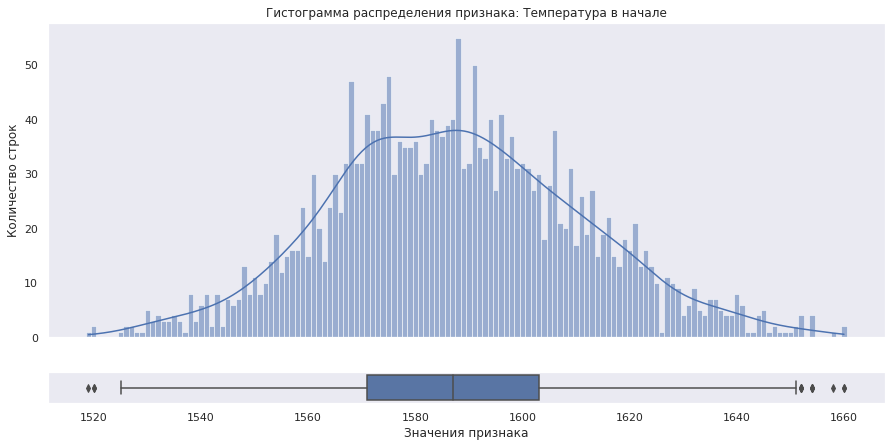

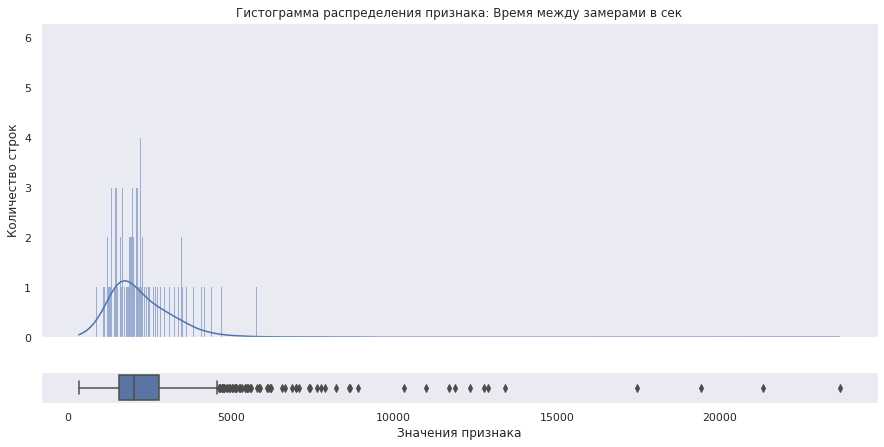

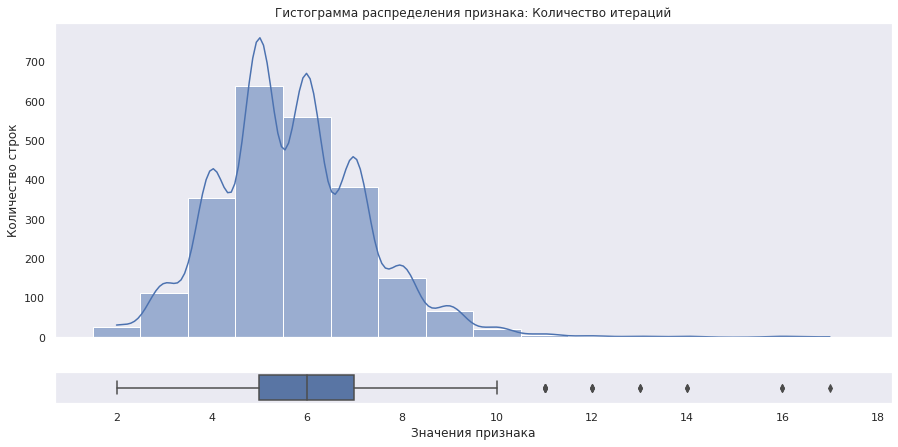

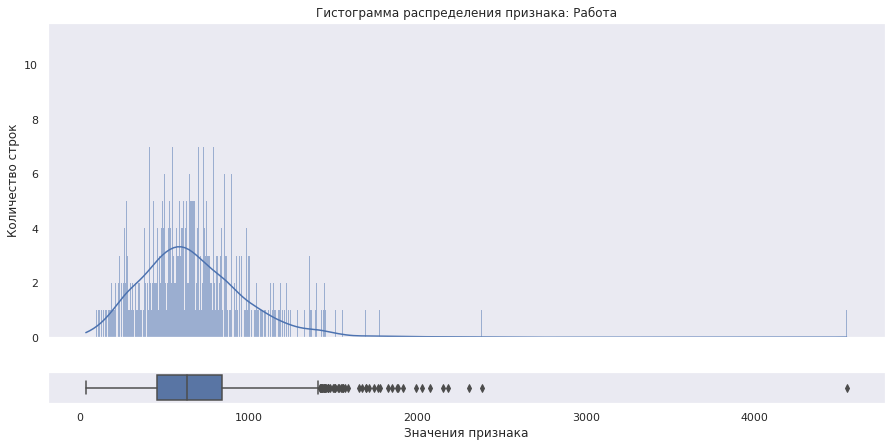

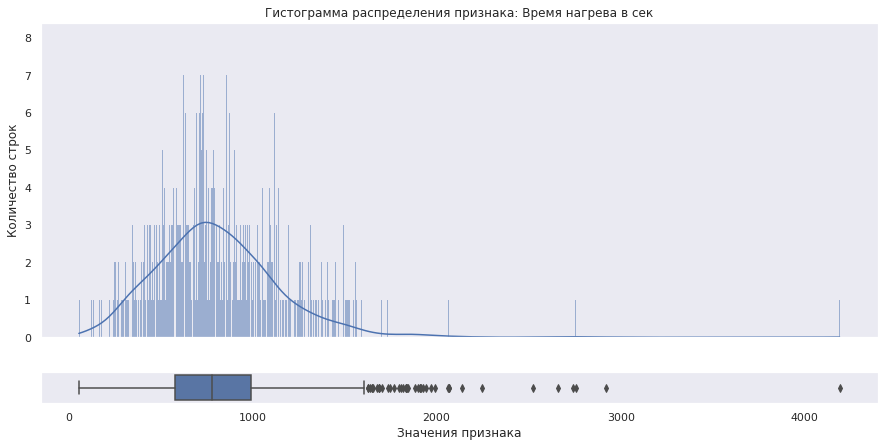

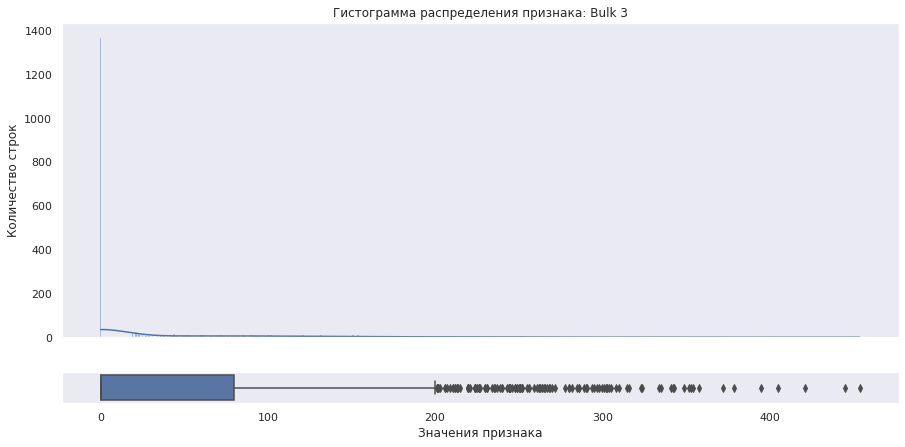

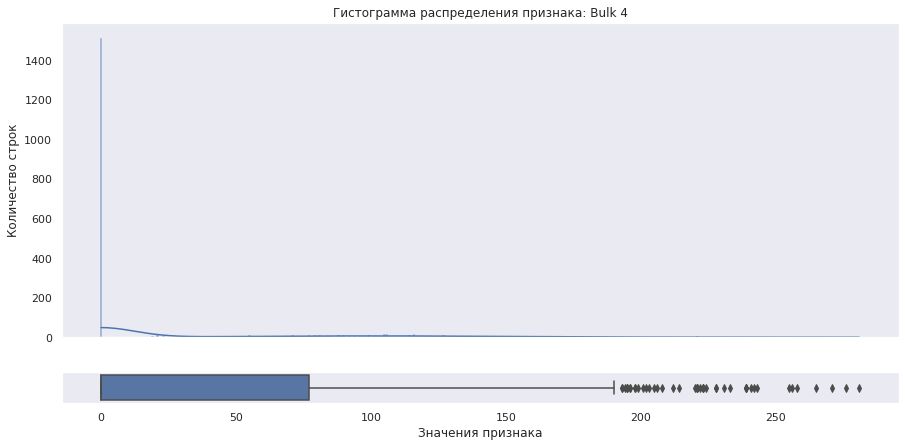

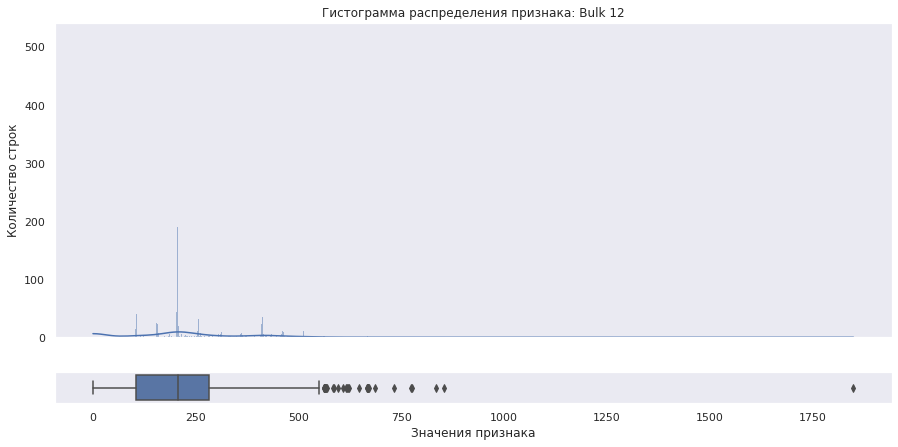

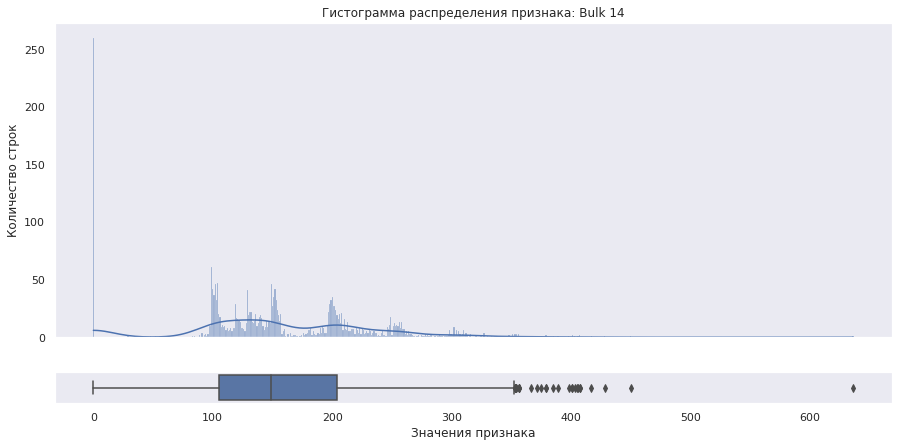

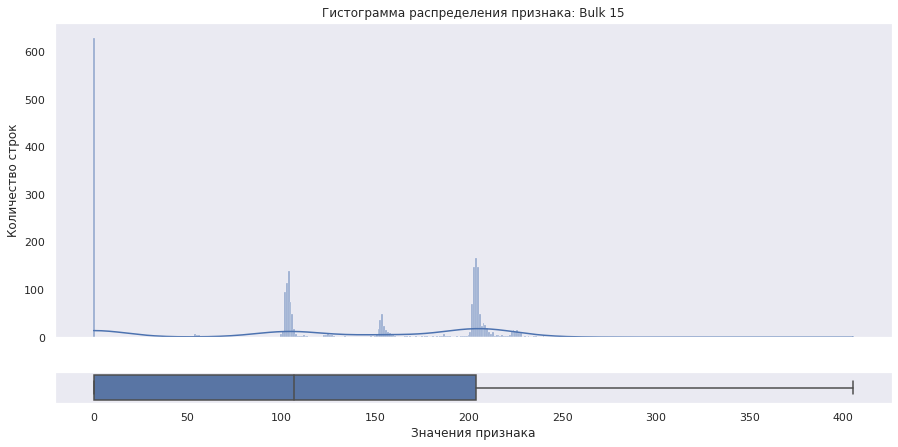

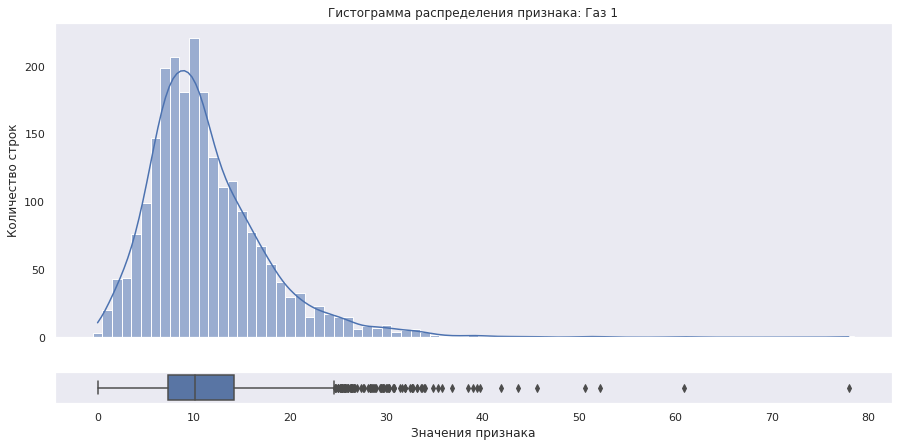

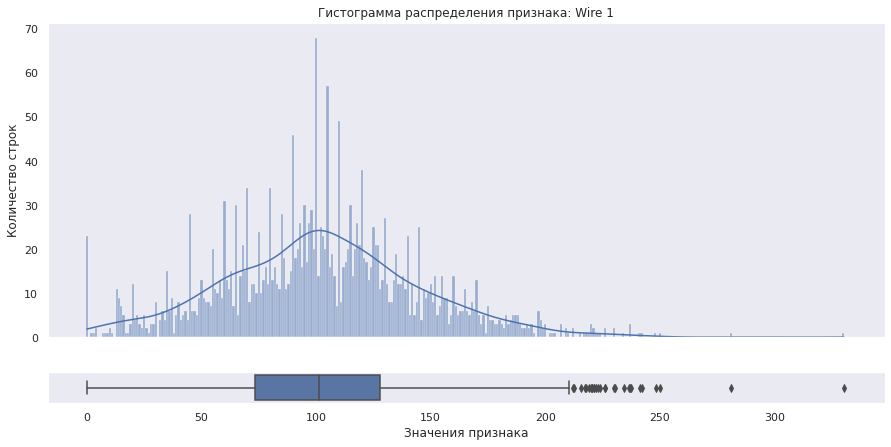

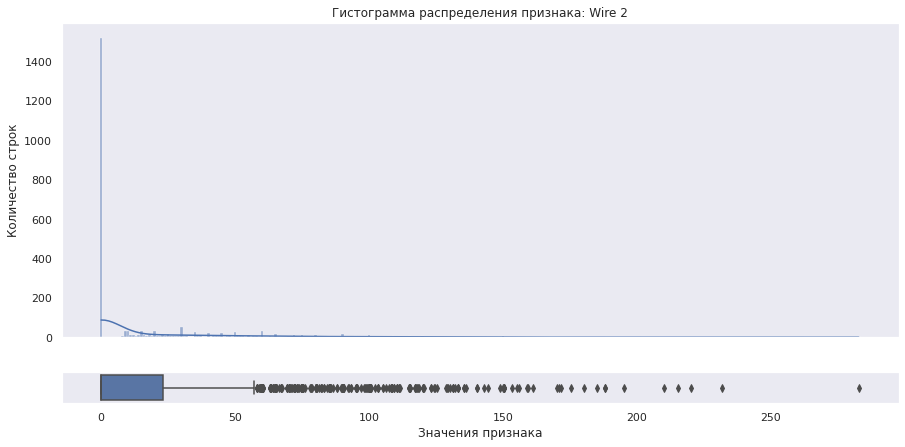

In [54]:
# Создание списка всех признаков, кроме 'key' и 'Температура в конце. Целевой признак'
features_for_plot = data.drop(['key', 'Температура в конце. Целевой признак'], axis=1).columns.tolist()

# Построение гистограмм и boxplot'ов для каждого признака
for feature in features_for_plot:
    _, [axs_hist, axs_box] = plt.subplots(2, 1, figsize=(15, 7), 
                                          sharex=True,
                                          gridspec_kw=dict(height_ratios=[10, 1]))
    
    # Гистограмма
    hist = sns.histplot(data=data, x=feature, kde=True, ax=axs_hist, discrete=True)
    hist.set_ylabel('Количество строк')
    hist.set_title('Гистограмма распределения признака: ' + feature)
    
    # Boxplot
    box = sns.boxplot(data=data, x=feature, ax=axs_box)
    box.set_xlabel('Значения признака')


In [55]:
data.describe()

,key,Температура в начале,Температура в конце. Целевой признак,Время между замерами в сек,Количество итераций,Работа,Время нагрева в сек,Bulk 3,Bulk 4,Bulk 12,Bulk 14,Bulk 15,Газ 1,Wire 1,Wire 2
count,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000
mean,1251.512258,1587.365161,1593.366022,2323.419785,5.696344,670.060566,807.988387,47.296774,37.331613,208.507957,153.971613,120.026667,11.378942,102.412198,17.605637
std,715.099053,23.623144,11.209581,1385.569302,1.605930,319.565380,340.888430,75.228262,58.670377,157.137873,81.398153,84.674380,6.395632,43.535263,33.642919
min,1.000000,1519.000000,1541.000000,339.000000,2.000000,33.430208,57.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.008399,0.000000,0.000000
25%,629.000000,1571.000000,1587.000000,1581.000000,5.000000,457.872635,581.000000,0.000000,0.000000,105.000000,105.000000,0.000000,7.282948,73.207679,0.000000
50%,1255.000000,1587.000000,1593.000000,2046.000000,6.000000,630.913482,778.000000,0.000000,0.000000,206.000000,149.000000,107.000000,10.100950,101.087998,0.000000
75%,1868.000000,1603.000000,1598.000000,2793.000000,7.000000,841.644330,993.000000,80.000000,77.000000,283.000000,204.000000,204.000000,14.217691,128.069763,23.102560
max,2499.000000,1660.000000,1653.000000,23674.000000,17.000000,4546.405812,4189.000000,454.000000,281.000000,1849.000000,636.000000,405.000000,77.995040,330.314424,282.780152


*Проанализируем статистические данные для каждого признака:*


* Температура в начале: 
Средняя температура в начале процесса составляет примерно 1593 °C, с небольшим стандартным отклонением около 23.62 °C. Распределение нормальное, выбросов мало, что указывает на стабильность начальной температуры.


* Температура в конце (Целевой признак):
Среднее значение конечной температуры составляет примерно 1587.37 °C с небольшим стандартным отклонением около 11.2 °C. Это говорит о том, что конечная температура имеет относительно узкое распределение вокруг среднего значения.

* Время между замерами в сек:
Среднее время между замерами составляет примерно 2323 секунды, со стандартным отклонением примерно 1385 секунд. Распределение времени замеров имеет большой разброс от минимального (339 секунд) до максимального значения (23674 секунды). Очень длинный хвост редких выбросов.

* Количество итераций:
Распределение нормальное, выбросов (больше 10 итераций) мало
 
* Работа:
Распределение Работы имеет большой разброс. Очень длинный хвост редких выбросов(>2000).

* Время нагрева в сек:
Этот признак аналогичен Работе, т.к. является её составляющей частью!


* Газ 1:
Распределение нормальное с хвостом справа, выбросов не так много

* Wire 1
Этот признак в процессе плавки добаляется чаще остальных добавок, поэтому распределение у него нормальное с хвостом справа, выбросов не так много

* Bulk 3, Bulk 4, Bulk 12, Bulk 14, Bulk 15, Wire 2:
Эти признаки в процессе плавки добаляется очень редко, соответсвенно у них среднее значение равно нулю, у распределения имеется огромный хвост справа, что говорит о частых и больших выбросах.


* Общий вывод:
По статистическим данным большинство признаков имеют относительно нормальное распределение, что указывает на умеренную вариабельность данных.


* Выбросы оставим, т.к. при их удалении возможны следующие последствия:

  - Потеря важной информации: Выбросы могут содержать важную информацию для модели, и удаление их приведёт к потере этих значимых данных. Например, удаления значимых экстремальных значений, которые фактически влияли на целевую переменную.

  - Смещение данных: Удаление выбросов может привести к искажению статистических характеристик данных, и тестовые данные могут не соответствовать новому распределению обучающих данных.

Text(0.5, 1.0, 'Тепловая карта матрицы корреляций')

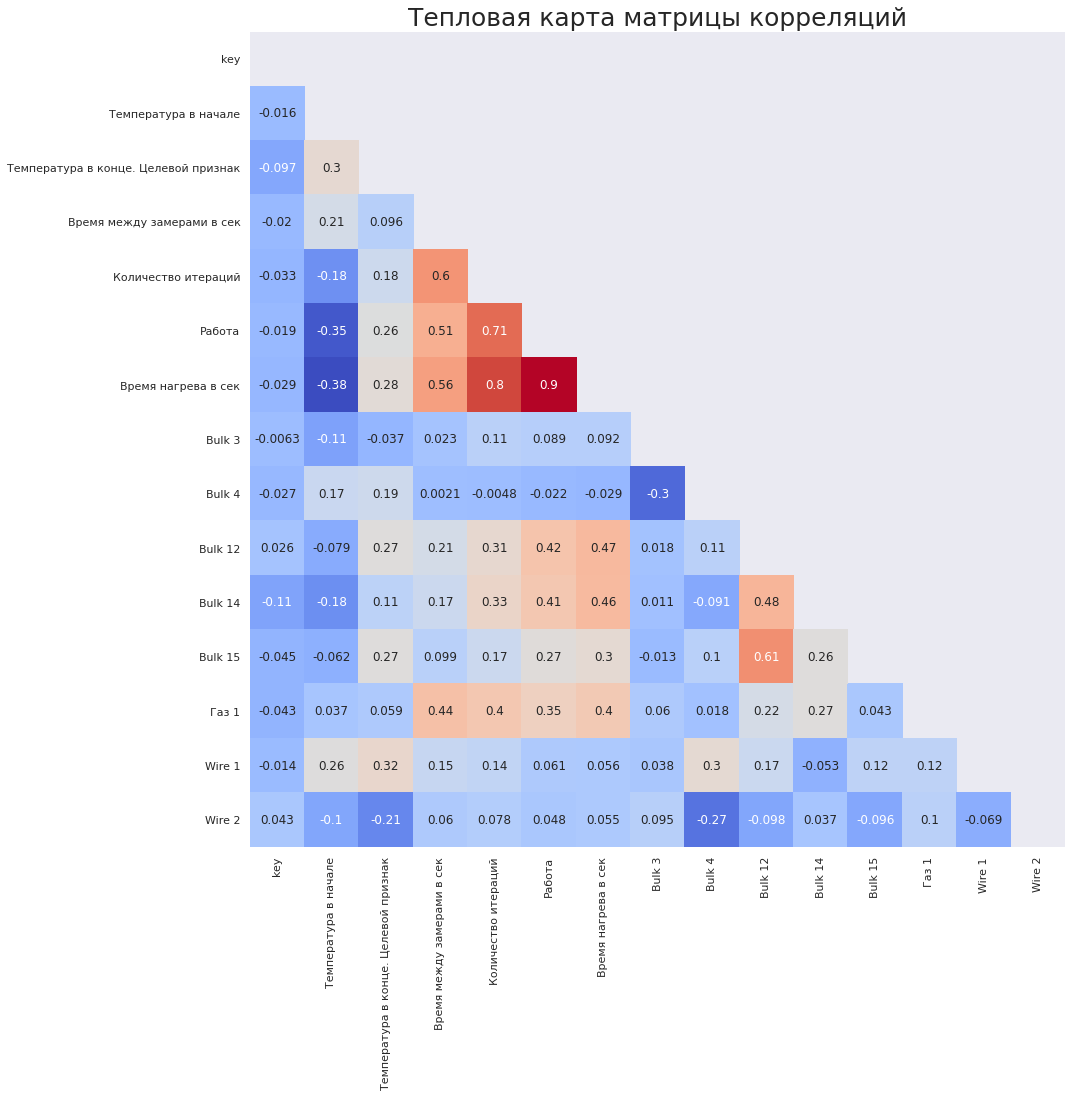

In [56]:
#строим тепловую карту корреляций
plt.figure(figsize=(15, 15))
matrix = np.triu(data.corr())
heatmap = sns.heatmap(data.corr(),
                      annot=True,
                      mask=matrix,
                      square=True,
                      cmap='coolwarm',
                      cbar=False,
                      fmt='.2g')
heatmap.set_title('Тепловая карта матрицы корреляций', fontsize=25)

In [57]:
data.corr()['Температура в конце. Целевой признак'].sort_values(ascending=False)[1:]

Wire 1                        0.317702
Температура в начале          0.301961
Время нагрева в сек           0.278558
Bulk 12                       0.267379
Bulk 15                       0.266386
Работа                        0.256466
Bulk 4                        0.188100
Количество итераций           0.180452
Bulk 14                       0.114520
Время между замерами в сек    0.096342
Газ 1                         0.059036
Bulk 3                       -0.036767
key                          -0.097052
Wire 2                       -0.206837
Name: Температура в конце. Целевой признак, dtype: float64

Целевой признак сильнее коррелирует с:
- `Wire 1`
- `Температура в начале` (ожидаемо)
- `Bulk 12`
- `Bulk 15`
- `Работа` (ожидаемо)

* связан прямо пропорционально, но даже с ними зависимость не слишком сильная

* Обратно пропорционально целевой признак связан сильнее всего с `Wire 2`, но также не слишком сильно.

* высококоррелирующие признаки (≥0.9) в данных: `Время нагрева в сек` и `Работа` (логично), при обучении Линейной Регресии, Работу удалим.

* Проверим данные на признаки, являющихся константными или квазиконстантными.

In [58]:
# Вычисление дисперсии признаков в процентах
variance_percent = (data.var() / data.mean()) * 100

In [59]:
variance_percent

key                                     40859.899853
Температура в начале                       35.155926
Температура в конце. Целевой признак        7.886116
Время между замерами в сек              82628.300823
Количество итераций                        45.274826
Работа                                  15240.716628
Время нагрева в сек                     14382.003979
Bulk 3                                  11965.491308
Bulk 4                                   9220.638670
Bulk 12                                 11842.383141
Bulk 14                                  4303.169356
Bulk 15                                  5973.464713
Газ 1                                     359.472040
Wire 1                                   1850.677106
Wire 2                                   6428.884276
dtype: float64

* таковых в данных нет

## Выводы по п.5. Построение единой таблицы

- для выделения целевого признака выделили последний замер температуры в отдельный признак-столбец `Температура в конце. Целевой признак`, создали признак `Время между замерами в сек`
- для вычисления признака `Работа`, нашли разницу между `Начало нагрева дугой` и `Конец нагрева дугой` и умножили на `Полную мощность`
- объединили датафреймы по номеру партии `key`, причем только по тем номерам, которые есть во всех датафреймах, чтобы не было пропусков значений, удалили признаки, у которых более 80% пропусков
- для выявления корреляций построили тепловую карту корреляций - сильных линейных корреляций с целевым признаком не выявили, высококоррелирующие признаков (≥0.9) - это 'Время нагрева в сек' и 'Работа', что логично.

# Разделение на выборки

In [60]:
features = data.drop(['Температура в конце. Целевой признак', 'key'], axis=1)
target = data['Температура в конце. Целевой признак']

По условию задачи, выборки разделены в пропорции 3:1 с random_state 301023

In [61]:
features_train, features_test, target_train, target_test = train_test_split(features,
                                                                            target,
                                                                            test_size=.25,
                                                                            random_state=RANDOM_STATE)

In [62]:
features_train.shape, features_test.shape, target_train.shape, target_test.shape

((1743, 13), (582, 13), (1743,), (582,))

* Масштабируем данные, т.к. модели, такие как (LightGBM, CatBoost, линейная регрессия), могут быть чувствительны к масштабированию данных.

In [64]:
# Применение масштабирования к обучающим и тестовым данным

scaler = StandardScaler()

# Применение масштабирования к обучающим и тестовым данным
scaled_features_train = pd.DataFrame(scaler.fit_transform(features_train), columns=features_train.columns)
scaled_features_test = pd.DataFrame(scaler.transform(features_test), columns=features_test.columns)

In [65]:
scaled_features_train.head()

,Температура в начале,Время между замерами в сек,Количество итераций,Работа,Время нагрева в сек,Bulk 3,Bulk 4,Bulk 12,Bulk 14,Bulk 15,Газ 1,Wire 1,Wire 2
0,-0.052519,-0.395407,-0.413137,-1.100961,-0.814320,-0.617872,-0.638065,-1.303487,0.593610,-1.408368,-0.133196,0.433561,1.609856
1,-1.153888,0.712208,0.843578,0.023917,0.705035,0.214781,-0.638065,-1.303487,0.605928,-1.408368,0.285604,1.001831,2.379593
2,-0.687924,-0.288518,-0.413137,-0.855524,-0.402953,0.650933,-0.638065,-0.509325,0.458116,-0.202492,-0.246140,-1.362680,0.150432
3,1.514814,-0.088683,-0.413137,-0.712541,-1.063542,-0.617872,0.296013,-1.303487,-1.882249,-1.408368,-1.213109,0.479922,-0.522340
4,1.345372,-1.114195,-1.669853,-1.546816,-1.468903,0.148698,-0.638065,-0.206787,-0.342536,0.435913,-0.211321,-0.051762,-0.522340


# Обучение моделей с кросс-валидацией и выбор лучшей по показателю MAE.

In [66]:
%%time

# Обучаем линейную регрессию

features_train_lr = scaled_features_train.drop(['Работа'], axis=1) #удаляю сильнокоррелированный признак

lr = LinearRegression()
scores = cross_val_score(lr, features_train_lr, target_train, scoring='neg_mean_absolute_error')
MAE_lr = -scores.mean()

print(f'MAE для линейной регрессии : {MAE_lr:.2f}')
print()

MAE для линейной регрессии : 6.04

CPU times: user 34.3 ms, sys: 32 ms, total: 66.3 ms
Wall time: 25.8 ms


In [67]:
%%time

#обучаем CatBoostRegressor

model = CatBoostRegressor(verbose=False, loss_function='MAE')
params = {
    'depth': [3,5,7], ## опробовано range(2,9)
    'learning_rate': [0.08],  ## опробовано [x/100 for x in range(1, 51)]
    'n_estimators': [100, 500, 950], ## опробовано range(100, 1000, 50)
    'random_state': [RANDOM_STATE],
}
cat_grid = GridSearchCV(model, params, cv=10, verbose=2, scoring='neg_mean_absolute_error')
cat_grid.fit(scaled_features_train, target_train)

MAE_cbr = -cat_grid.best_score_
print()
print(f'MAE для CatBoostRegressor: {MAE_cbr:.2f}')
print('Лучшие параметры:', cat_grid.best_params_)

Fitting 10 folds for each of 9 candidates, totalling 90 fits
[CV] END depth=3, learning_rate=0.08, n_estimators=100, random_state=301023; total time=   1.2s
[CV] END depth=3, learning_rate=0.08, n_estimators=100, random_state=301023; total time=   1.4s
[CV] END depth=3, learning_rate=0.08, n_estimators=100, random_state=301023; total time=   1.1s
[CV] END depth=3, learning_rate=0.08, n_estimators=100, random_state=301023; total time=   1.3s
[CV] END depth=3, learning_rate=0.08, n_estimators=100, random_state=301023; total time=   1.2s
[CV] END depth=3, learning_rate=0.08, n_estimators=100, random_state=301023; total time=   0.7s
[CV] END depth=3, learning_rate=0.08, n_estimators=100, random_state=301023; total time=   0.7s
[CV] END depth=3, learning_rate=0.08, n_estimators=100, random_state=301023; total time=   0.7s
[CV] END depth=3, learning_rate=0.08, n_estimators=100, random_state=301023; total time=   0.7s
[CV] END depth=3, learning_rate=0.08, n_estimators=100, random_state=301023

In [68]:
%%time

#обучаю LGBMRegressor

model = LGBMRegressor()
params = {
    'metric': ['mae'],
    'max_depth': [3,5,8],  ## опробовано range(2,9)
    'learning_rate': [0.08],  ## опробовано [x/100 for x in range(1, 51)]
    'n_estimators': [100, 500, 950],  ## опробовано range(100, 1000, 50)
    'random_state': [RANDOM_STATE],
}

lgbm_grid = GridSearchCV(model, params, cv=10, verbose=2, scoring='neg_mean_absolute_error')
lgbm_grid.fit(scaled_features_train, target_train)

MAE_lgbm = -lgbm_grid.best_score_
print()
print(f'MAE для LGBMRegressor: {MAE_lgbm:.2f}')
print('Лучшие параметры:', lgbm_grid.best_params_)

Fitting 10 folds for each of 9 candidates, totalling 90 fits
[CV] END learning_rate=0.08, max_depth=3, metric=mae, n_estimators=100, random_state=301023; total time=   0.2s
[CV] END learning_rate=0.08, max_depth=3, metric=mae, n_estimators=100, random_state=301023; total time=   0.3s
[CV] END learning_rate=0.08, max_depth=3, metric=mae, n_estimators=100, random_state=301023; total time=   0.3s
[CV] END learning_rate=0.08, max_depth=3, metric=mae, n_estimators=100, random_state=301023; total time=   0.3s
[CV] END learning_rate=0.08, max_depth=3, metric=mae, n_estimators=100, random_state=301023; total time=   0.3s
[CV] END learning_rate=0.08, max_depth=3, metric=mae, n_estimators=100, random_state=301023; total time=   0.2s
[CV] END learning_rate=0.08, max_depth=3, metric=mae, n_estimators=100, random_state=301023; total time=   0.3s
[CV] END learning_rate=0.08, max_depth=3, metric=mae, n_estimators=100, random_state=301023; total time=   0.3s
[CV] END learning_rate=0.08, max_depth=3, m

In [69]:
#собираю все MAE в таблицу

index_mae = ['LinearRegression',
         'CatBoostRegressor',
         'LGBMRegressor'
        ]

data_mae = {'MAE на обучающей выборке': [MAE_lr,
                                     MAE_cbr,
                                     MAE_lgbm
                                    ]}

kpi = pd.DataFrame(data=data_mae, index=index_mae)

kpi.sort_values(by='MAE на обучающей выборке', ascending=False)

,MAE на обучающей выборке
LinearRegression,6.040862
LGBMRegressor,5.999673
CatBoostRegressor,5.912229


## Вывод по п.6. Обучение моделей

Наилучший результат дал CatBoostRegressor - MAE = 5.91. Проведём тестирование CatBoostRegressor

# Предсказание на тестовой выборке

In [70]:
# Оценим модель с лучшими параметрами на отложенной тестовой выборке
best_model = cat_grid.best_estimator_
predict_test = best_model.predict(scaled_features_test)
MAE_test = mean_absolute_error(target_test, predict_test)

# Результаты
print(f'MAE для CatBoostRegressor на train: {MAE_cbr:.2f}')
print('Лучшие параметры:', cat_grid.best_params_)
print()
print(f'!!!MAE для CatBoostRegressor на TEST!!! {MAE_test:.2f}')

MAE для CatBoostRegressor на train: 5.91
Лучшие параметры: {'depth': 3, 'learning_rate': 0.08, 'n_estimators': 950, 'random_state': 301023}

!!!MAE для CatBoostRegressor на TEST!!! 5.86


In [71]:
#  Оценка R2
#  модели с лучшими параметрами на отложенной тестовой выборке
r2_test = r2_score(target_test, predict_test)

# Вывод результатов коэффициента детерминации (r2 score)
print(f'r2 score для CatBoostRegressor на TEST: {r2_test:.4f}')

r2 score для CatBoostRegressor на TEST: 0.4816


* R2=0.4816
* Это значит, что примерно 48.16% изменчивости зависимой переменной (финальной температуры) объясняется использованными предикторами (независимыми переменными) в модели.


* Итак, в данном случае модель достаточно хорошо объясняет изменения в финальной температуре, используя выбранные предикторы, но все еще есть значительная часть изменчивости, которая не объясняется этой моделью.

## Вывод по п.8. Предсказание на тестовой выборке

MAE на тестовой выборке CatBoostRegressor: 5.86

r2 score для CatBoostRegressor на TEST: 0.48

# Проверка модели на вменяемость

In [72]:
for strategy in ['mean', 'median']:
    dummy = DummyRegressor(strategy=strategy)
    dummy.fit(scaled_features_train, target_train)   
    predict = dummy.predict(scaled_features_test)   
    MAE_dummy = mean_absolute_error(target_test, predict)   
    print('Для стратегии', strategy, 'MAE -', MAE_dummy)

Для стратегии mean MAE - 7.95628858093148
Для стратегии median MAE - 7.920962199312715


Значения MAE, показанные DummyRegressor, оказались выше, чем у CatBoostRegressor. 

Поэтому считаем, что модель прошла проверку на вменяемость

# Анализ значимости признаков для предсказания

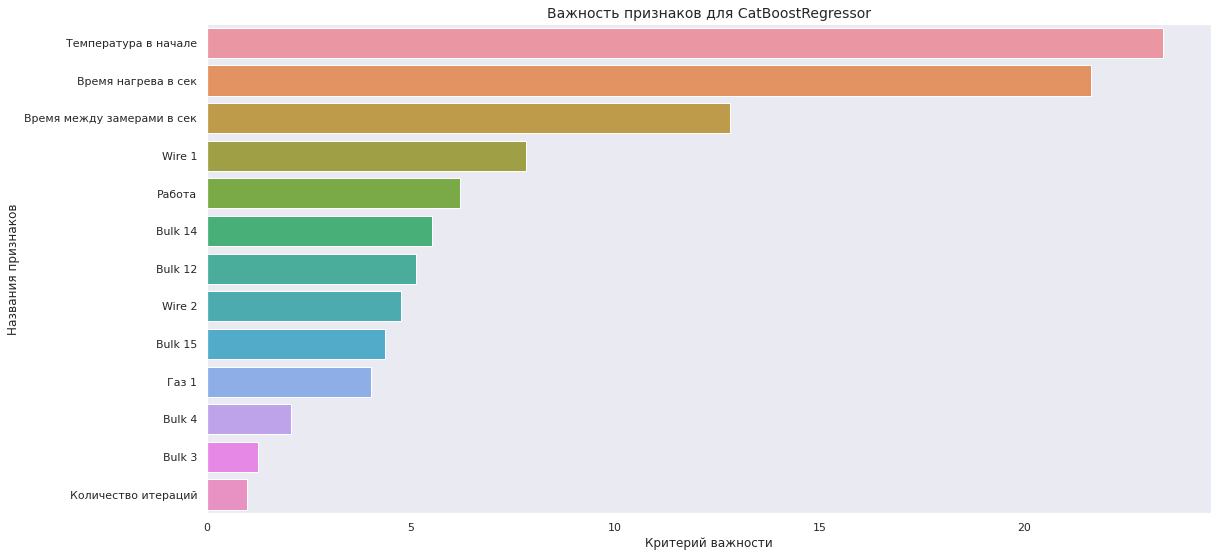

In [73]:
plot_data = {
    'features': scaled_features_test.columns,
    'feature_importances': best_model.feature_importances_,
}
plot_data = pd.DataFrame(plot_data)
plot_data.sort_values(by='feature_importances', ascending=False, inplace=True)
plt.figure(figsize=(18, 9))
sns.barplot(x=plot_data['feature_importances'], y=plot_data['features'])
plt.title('Важность признаков для CatBoostRegressor', fontsize=14)
plt.xlabel('Критерий важности')
plt.ylabel('Названия признаков')
plt.show()

## Вывод по п.9 Значимость признаков для предсказания

* Полученный анализ важности признаков представляет собой ключевую информацию для понимания того, какие параметры оказывают значительное влияние на целевую переменную.


* На основании графика важности признаков можно сделать следующие выводы:


1. Температура в начале: Высокая важность этого признака говорит о том, что начальная температура имеет значительное влияние на финальную температуру стали. Это логично, поскольку она является отправной точкой для процесса нагрева.


2. Время нагрева в секундах: Длительность процесса нагрева оказывает существенное воздействие на финальную температуру стали. Возможно, длительность нагрева влияет на эффективность термической обработки стали.


3. Время между замерами в секундах: Возможно, интервалы между измерениями температуры влияют на процесс обработки стали и её финальные характеристики.


4. Wire 1: Вероятно, это связано с типом и количеством добавляемых материалов в процессе производства стали, что может существенно влиять на её характеристики.


5. Работа: Количество энергии, затраченной на процесс, имеет влияние на конечную температуру стали. Это может отражать процесс и интенсивность термической обработки.


**Это ценная информация для дальнейшего улучшения и оптимизации процесса обработки стали, позволяет сосредоточить внимание на ключевых параметрах, которые имеют наибольшее влияние на финальный результат.**

# Общие выводы по работе

- В результате EDA были выявлены:
  - пропуски, в том числе 14-17 июля, скорее всего, из-за остановки производства
  - выбросы
  - разное кол-во и значения партий (key)
- При подготовке данных, в опредлённых признаках выбросы были удалены
- Пропуски были частично заполнены нулями в том случае, если легирующие добавки не подавались
- Были выведены дополнительные признаки: время между замерами температуры и работа (энергия, потраченная на нагрев)
- Полученные таблицы были объединены по номеру партии key (по тем номерам партий, которые были во всех таблицах).
- Также была изучена корреляция признаков, в результате не выявлено сильной зависимости каких-либо признаков с целевым.
- Масштабированы признаки
- Решил проверить три модели: Линейная регрессия, CatBoostRegressor, LGBMRegressor.
- Лучший целевой показатель на тренировочных данных (MAE 5.91) показала модель CatBoostRegressor.
- Лучшие параметры: {'depth': 3, 'learning_rate': 0.08, 'n_estimators': 950, 'random_state': 301023}
- MAE на тестовых данных получился 5.86
- То есть модель ошибается на ≈ 5.86 градуса.
- Самые важные показатели: Температура в начале, Время нагрева в секундах, Время между замерами в секундах, Wire 1, Работа
- Получившийся результат проходит по условиям задачи | Отлично | MAE ≤ 6.0 |

# Рекомендации для заказчика

Эти рекомендации могут помочь заказчику более эффективно оптимизировать процессы и снизить затраты энергии, повышая при этом качество производства.

* Оптимизация начальной температуры: 

Исходя из значительного влияния начальной температуры на финальные результаты, рекомендуется тщательно контролировать и оптимизировать этот параметр для более эффективного процесса обработки.

* Мониторинг длительности нагрева: 

Требуется дальнейшее исследование влияния продолжительности процесса нагрева на финальные характеристики стали. Оптимизация времени нагрева может существенно улучшить результаты производства.

* Оптимизация времени между замерами: 

Интервалы между измерениями температуры также имеют влияние на процесс обработки стали. Следует проанализировать оптимальные интервалы измерений для повышения эффективности.

* Управление типами и количеством добавляемых материалов: 

Поскольку показатель Wire 1 оказывает влияние на финальную температуру, необходимо более тщательно контролировать и оптимизировать добавляемые материалы.

* Эффективное использование энергии: 

Количество затрачиваемой энергии (параметр Работа) влияет на конечную температуру стали. Рекомендуется исследовать методы оптимизации потребления энергии для более эффективного процесса производства.

* Структурирование данных и обработка пропусков: 

Необходимо внимательное отслеживание и обработка пропусков в данных для предотвращения потери важной информации в будущем.